# Transpilation for utility scale hardware


In this exercise, you will learn how to build and train a simple Variational Quantum Classifier (VQC) on an ideal backend using the Qiskit Patterns workflow. Then, you will learn how to reduce the depth of the VQC and test how it would run on hardware. We will then scale up the example to 50 qubits, reduce the depth again and then run it on real hardware.


Let's start by importing all the libraries that will be needed in this Lab:

# Imports

In [201]:
### Install Qiskit and relevant packages, if needed
### IMPORTANT: Make sure you are on 3.10 > python < 3.12
%pip install qiskit[visualization]==1.4
%pip install qiskit-ibm-runtime
%pip install qiskit-aer
%pip install graphviz
%pip install qiskit-serverless -U
%pip install qiskit-transpiler-service -U
%pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git -U

  Using cached qiskit-1.4.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached qiskit-1.4.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.7 MB)
  Attempting uninstall: qiskit
    Found existing installation: qiskit 1.4.2
    Uninstalling qiskit-1.4.2:
      Successfully uninstalled qiskit-1.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-ibm-runtime 0.37.0 requires qiskit>=1.4.1, but you have qiskit 1.4.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
  Using cached qiskit-2.0.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached qiskit-2.0.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.5 MB)
  Attempting uninstall: qiskit
    Found existing installation: qiskit 1.4.0
    Uninstalling qiskit-1.4.0:
      Succes

Now, let's run our imports and setup the grader

In [202]:
# Import all in one cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit import ParameterVector


from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

## Part 1: Design a VQC on an ideal backend

Variational quantum classifiers (VQCs) are a type of variational quantum algorithm that can solve certain types of classification problems. In particular, VQCs feature a hybrid architecture. This architecture is based on an ansatz in the form of a parametrized quantum circuit applied onto an initial state. The output is measured in the form of a cost function, which is classically optimized over the circuit's parameters until we converge to a minimum.

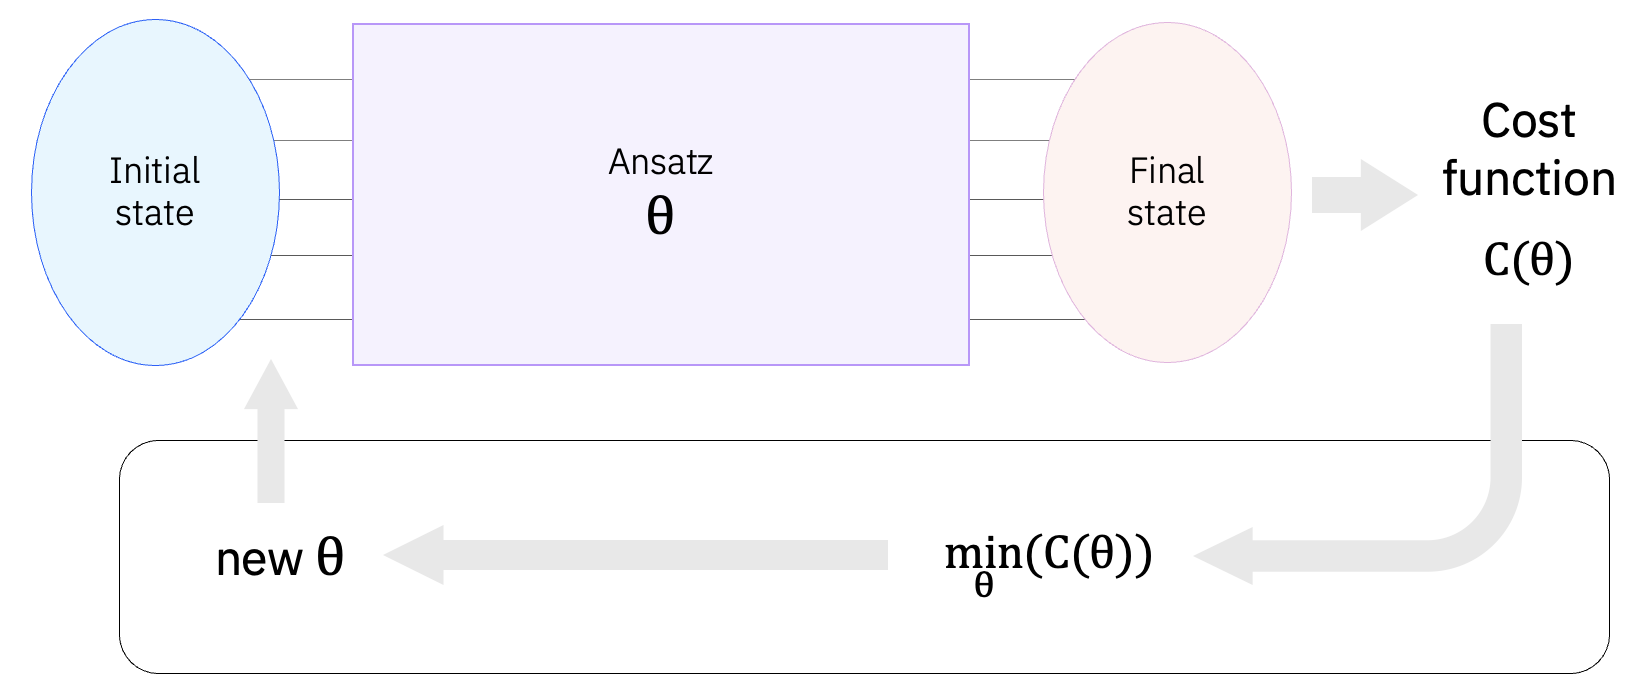

In this Lab, you are given a list of 10 birds:

 > Falcon, Hummingbird, Eagle, Osprey, Heron, Peacock, Parrot, Swan, Toucan, Cardinal.

The first five birds in the list are IBM Quantum birds, since processor types were named after them - check them out [here](https://docs.quantum.ibm.com/run/processor-types). The rest of them are non-IBM Quantum birds.

The dataset is given to you in the form of a dictionary, *bird_dataset.csv*. Each bird corresponds to an entry, and it is associated with a 5-qubit quantum state given in a _statevector_ form. Therefore, for each bird you will find $2^5 = 32$ coefficients.

For this problem, IBM Quantum birds are associated with entangled quantum states, while non-IBM quantum birds are associated to non-entangled (product) quantum states. Turns out that distinguishing between entangled and non-entangled quantum states is not an easy problem in general! The goal of this part of the Lab is to build a VQC that is able to distinguish the two sets of birds. 

But do not worry! We will guide you through all the steps of the algorithm using a workflow based on [Qiskit Patterns](https://www.ibm.com/quantum/blog/qiskit-patterns)**.

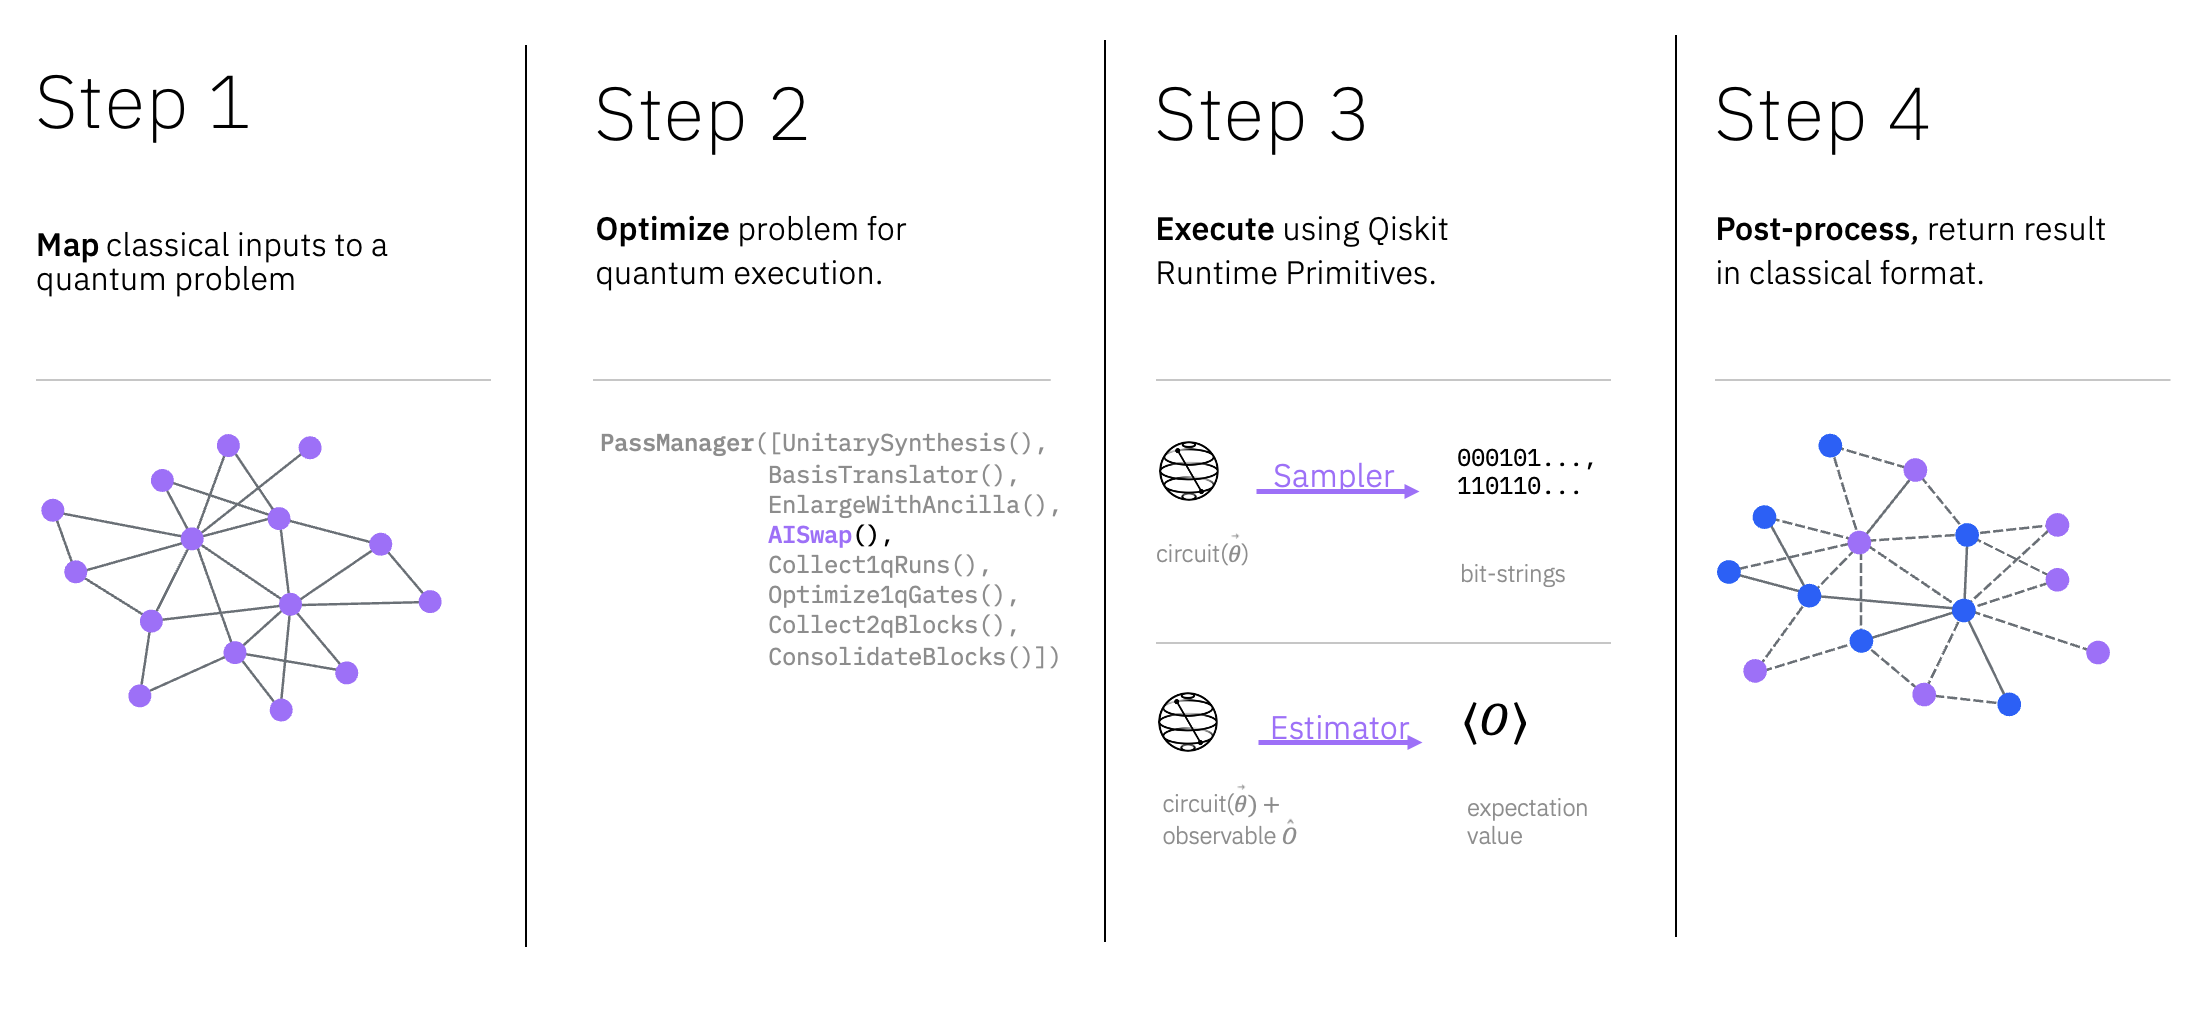

** Note that Qiskit Patterns represent a general workflow that can be applied to any type of problem, not only variational quantum algorithms!

### Step 1: Map classical inputs to a quantum problem

In this step of Qiskit Patterns, we are interested in translating a problem into a quantum circuit and a set of measurements that can reasonably run on quantum hardware. Note that this is in general a hard problem, so here's a list of things to take into account:

- We want to choose problems that are classically hard. Distinguishing between entangled and non-entangled states is a classically hard problem, even though we are choosing a small-scale problem for our learning purposes.
- We need to translate the outcomes into an expectation value or a _cost function_. A _cost function_ is a problem-specific function that defines the problem's outcome as something to be minimized or maximized, and it is typically used for variational quantum algorithms with various applications in chemistry, machine learning, finance, optimization, etc.
- When possible, we should keep in mind the limitations and advantages of the hardware that we are going to use. In particular, the backend's connectivity is important: we want to map the problem to a circuit that is as close as possible to the IBM Quantum processors’ heavy-hex topology to avoid having to implement a lot of SWAP gates.

For now, let's first retrieve the classical data, which in this case are the _statevector_ coefficients for each of the birds.

<div class="alert alert-block alert-danger">

**Please note:** This notebook needs additional scripts located in the same folder. Ensure you transfer and store these files in the same directory as the notebook in your environment. **The files that are required are:**  `birds_dataset.csv`, `params_0_list.npy` and `opt_params_shallow_VQC.npy`.

</div>

In [203]:
# Define num_qubits, the number of qubits, for the rest of the Lab
num_qubits = 5

# Load the dictionary 
birds_dataset = pd.read_csv('birds_dataset.csv') 

# Check if the dataset is loaded correctly - coefficients should be complex numbers
for i in range(2**num_qubits):
    key = 'c%.0f' %i
    birds_dataset[key] = birds_dataset[key].astype(np.complex128)

# Print the dataset
birds_dataset

,names,c0,c1,c2,c3,c4,c5,c6,c7,c8,...,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31
0,Falcon,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j
1,Hummingbird,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j
2,Eagle,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j
3,Osprey,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
4,Heron,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.707107+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.707107+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
5,Peacock,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
6,Parrot,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
7,Swan,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
8,Toucan,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
9,Cardinal,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,...,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j


<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 1:</b> 

Retrieve the coefficients of each of the quantum states from the dictionary. Save them in a list of lists containing complex numbers: ```[[], [], [], ...]```. Create a corresponding list of labels with label 1 for IBM Quantum birds and label 0 for non-IBM Quantum birds: ```[int, int, ...]```.
    
</div>

In [204]:
list_coefficients = []
for i in range(10):
    amplitude_state = []
    for j in range(2**num_qubits):
        key = 'c%.0f' %j
        amplitude_state.append(birds_dataset[key][i])
    list_coefficients.append(amplitude_state)

list_labels = [1,1,1,1,1,0,0,0,0,0]
print(list_coefficients)

[[np.complex128(0.7071067811865476+0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0.7071067811865476+0j)], [np.complex128(0j), np.complex128(0.7071067811865476+0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.complex128(0j), np.compl

Now that the data is ready, we want to map it onto the quantum circuit. In this case, we are going to use the **amplitude embedding** technique, which can be easily implemented in Qiskit via [initialization](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.Initialize). Since each of our $32$ coefficients corresponds to the amplitude of one of the basis states of a 5-qubit Hilbert space, the amplitude embedding is a straightforward mapping for this kind of dataset. As we will see later, `qc.initialize` is a general function that can map any quantum state. However, this function can lead to very deep circuits. Given that we don't yet have full information on the dataset, we will use this mapping approach for now.

For more general classification problems, we can consider other mappings. The choice of the mapping should depend on the structure of the dataset that we are given. In general, the data is mapped onto the parameters of a set of parametrized quantum gates. A typical example is the [ZZ Feature Map](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap).

Let's build the amplitude embedding circuit and take a look at it:

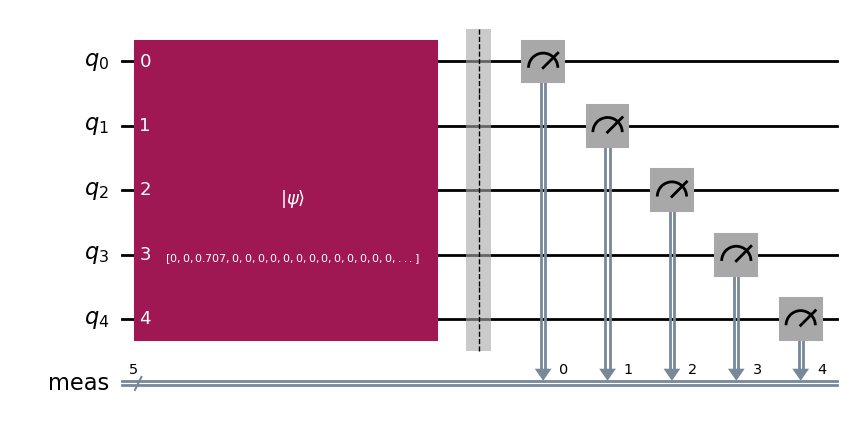

In [205]:
index_bird = 2 # You can check different birds by changing the index
amplitudes = list_coefficients[index_bird]
# Build the amplitude embedding 
qc = QuantumCircuit(5)
qc.initialize(amplitudes, range(num_qubits))
qc.measure_all()

# Draw the amplitude embedding circuit
qc.draw(output="mpl")

If we decompose the circuit before drawing it, we can better see its structure. As mentioned above, the ```qc.initialize()```function leads to a very deep circuit. In fact, the problem of state preparation, which aims at mapping an arbitrary quantum state onto a quantum circuit efficiently, is still an open research problem.

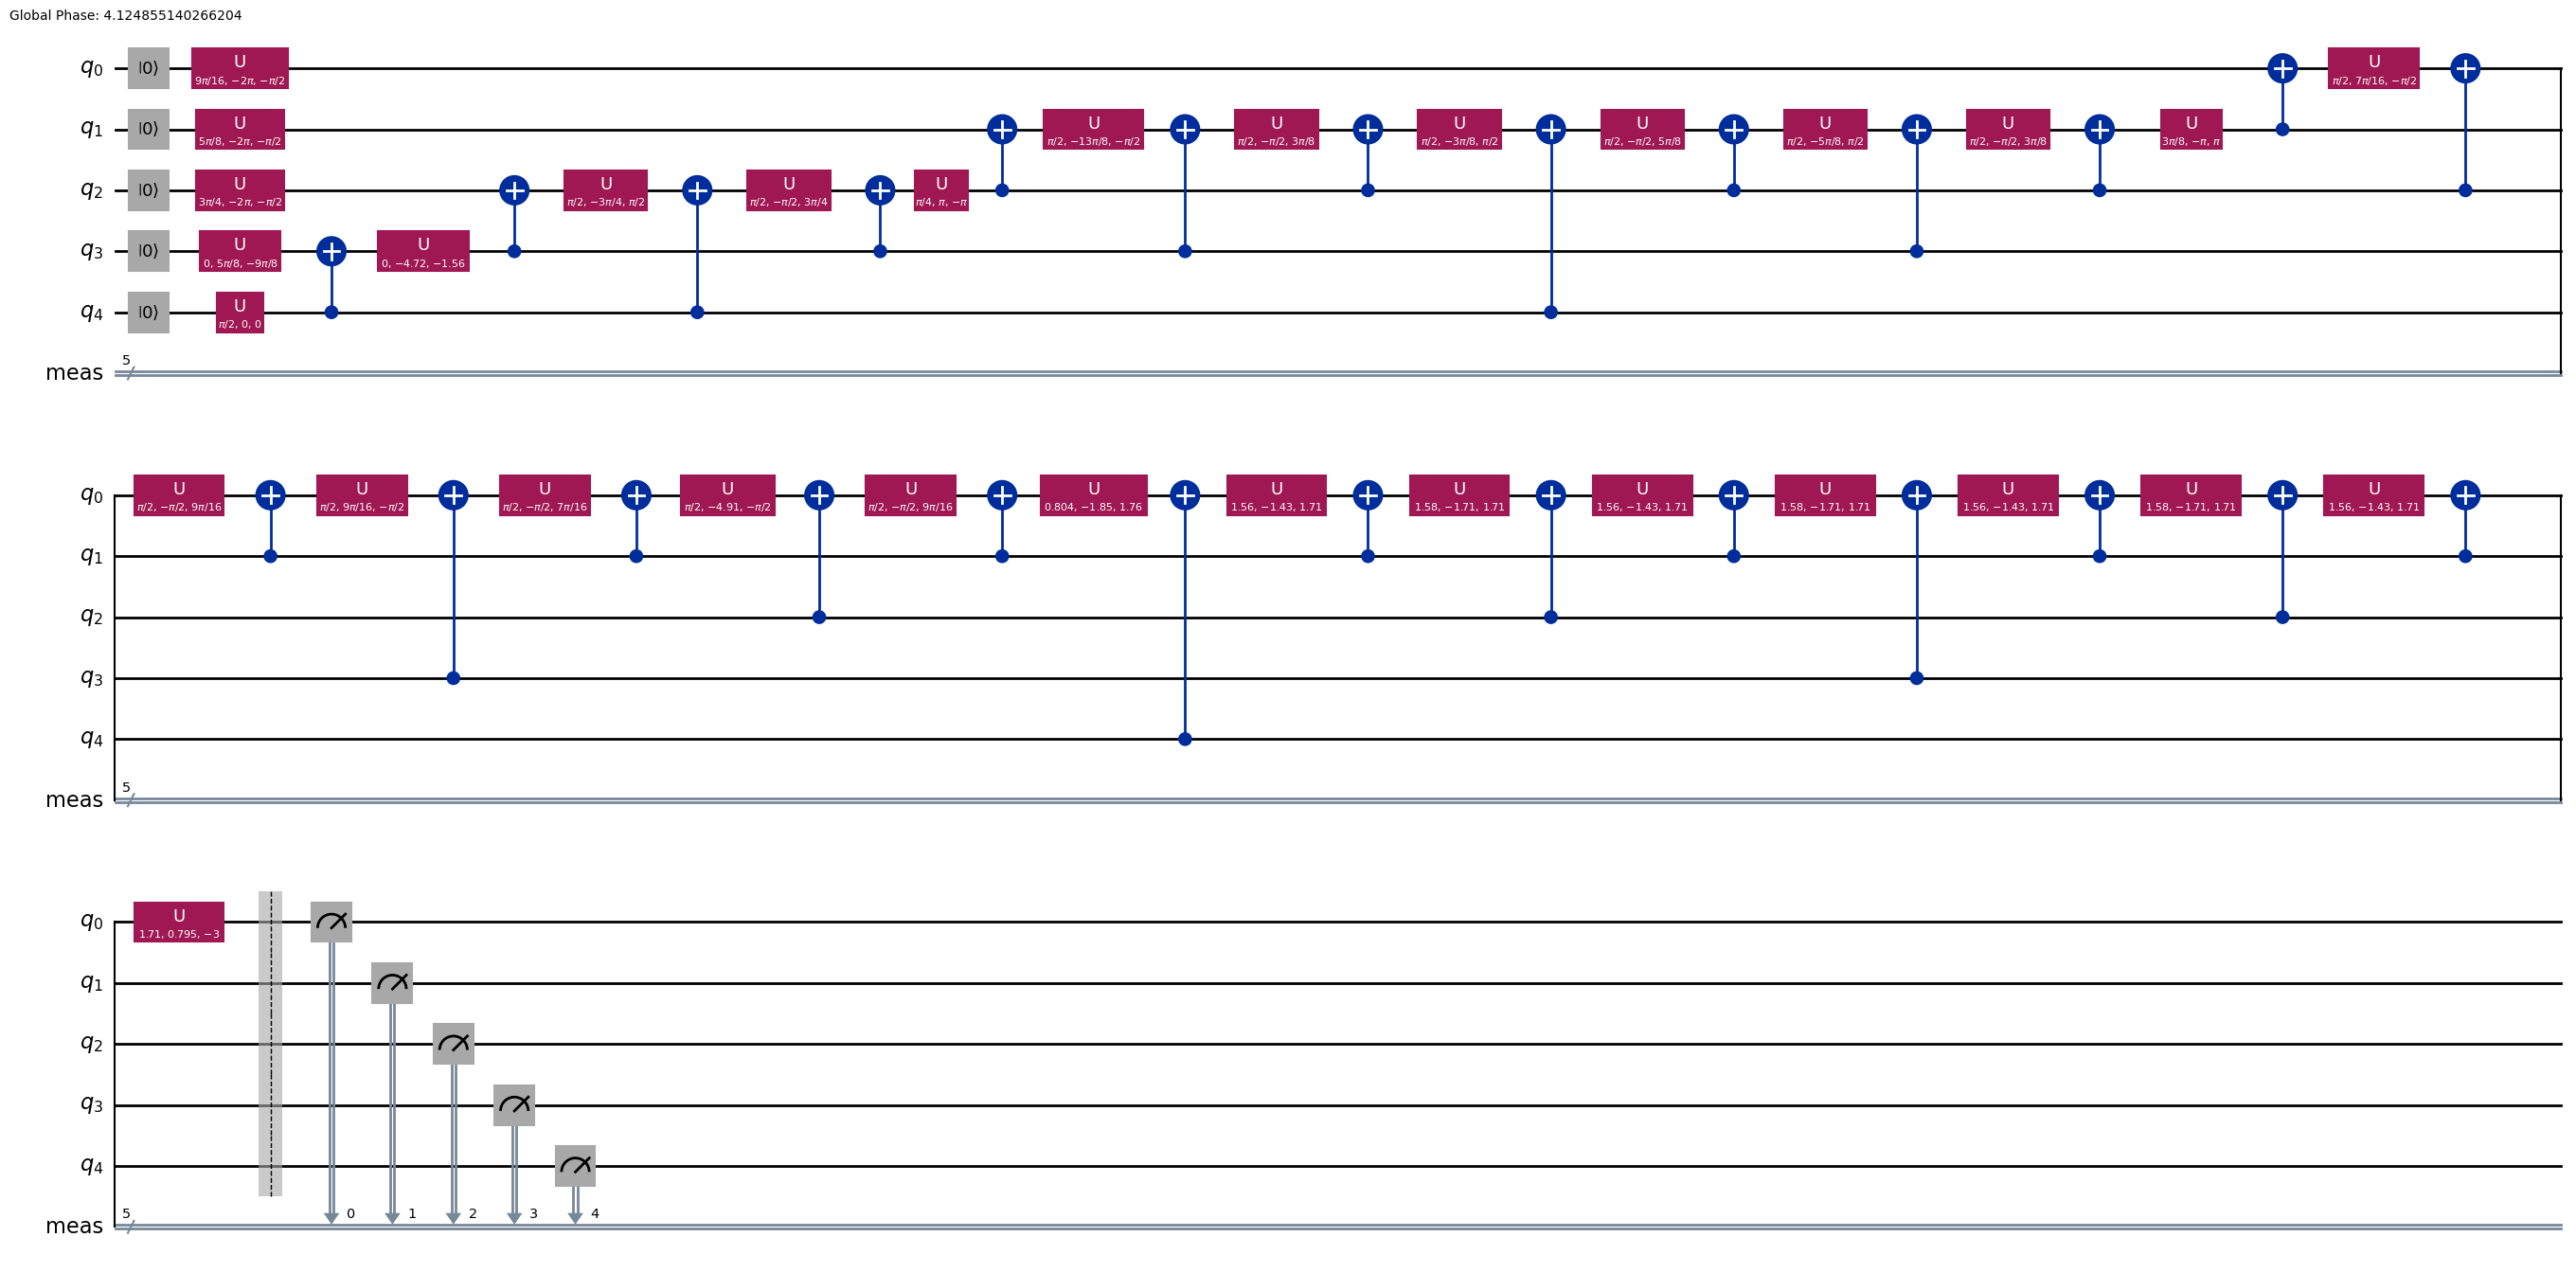

In [206]:
# Draw the decomposition of the amplitude embedding circuit
qc.decompose(reps=8).draw(output="mpl", fold=40)

Once the initial state is prepared, we need to build a variational ansatz for the VQC. The ansatz typically consists of a collection of parametrized rotation gates and entangling layers that are repeated a given number of times. By tuning the parameters of the rotations, we can explore a specific area of the Hilbert space. 

Choosing the right ansatz that allows us to converge to the desired solution is not an easy problem. In general, there are a few trade-offs to consider:

- **Speed**: By reducing the search space, and thus the number of gates and the depth of the ansatz, the algorithm can run faster.
- **Accuracy**: Reducing the search space could risk excluding the actual solution to the problem, leading to suboptimal solutions.
- **Noise**: Deeper circuits are affected by noise, so we need to experiment with our ansatz's connectivity, gates, and gate fidelity.

> If you want to know more about how to design the ansatz for your variational quantum circuits, we strongly recommend the [Variational algorithm design](https://learning.quantum.ibm.com/course/variational-algorithm-design) course in the IBM Learning Platform. 

By checking the [Qiskit circuit library](https://docs.quantum.ibm.com/api/qiskit/circuit_library#n-local-circuits) you will see that there are many architectures to build an ansatz, such as the [`TwoLocal`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal), the [`EfficientSU2`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.EfficientSU2) and the [`RealAmplitudes`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RealAmplitudes) ansatzes. For this exercise, we choose the [`RealAmplitudes`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RealAmplitudes) ansatz.

<a id="exercise2"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 2:</b> 

Build the ansatz using the ```RealAmplitudes``` circuit from the Qiskit circuit library. The ansatz should look as follows:

</div>

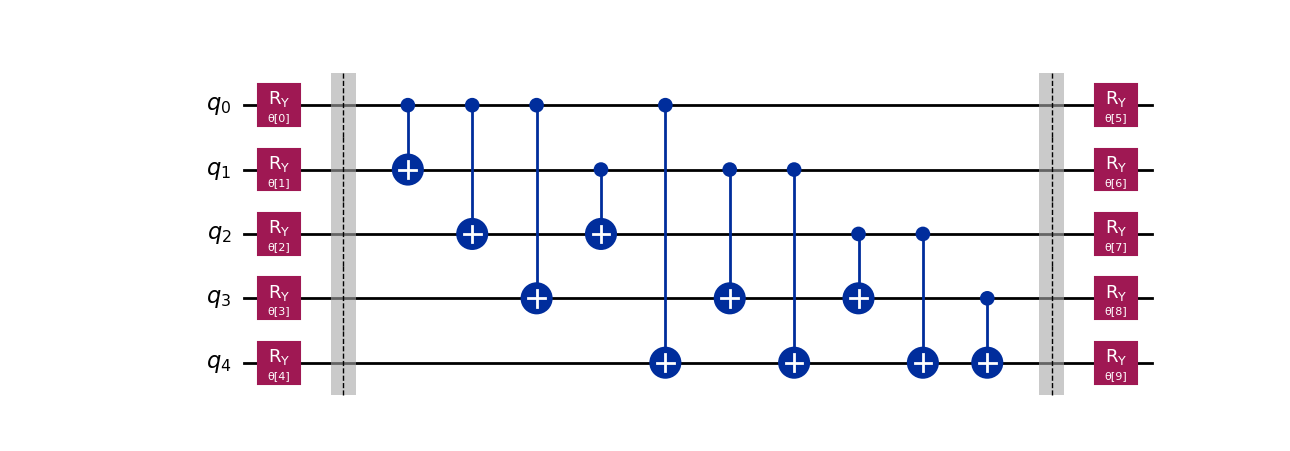

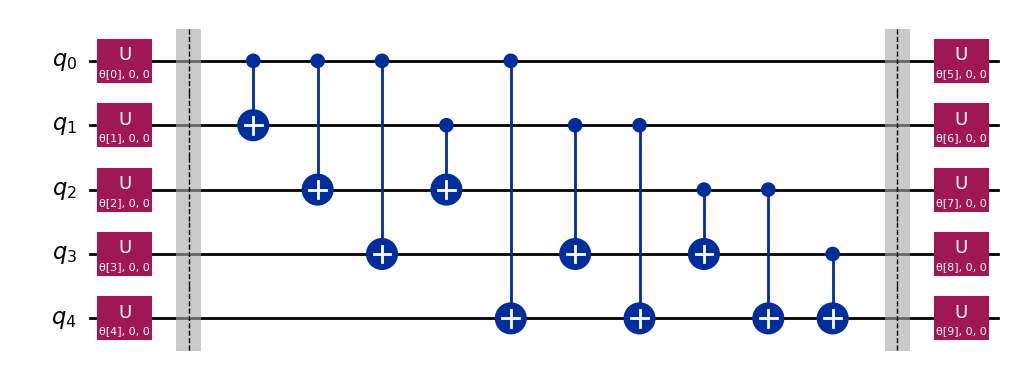

In [207]:
num_qubits = 5
reps = 1
entanglement = "full"
ansatz = RealAmplitudes(num_qubits=num_qubits, entanglement=entanglement, reps=reps, insert_barriers=True)
ansatz.decompose(reps=8).draw(output="mpl", fold=40)

### Steps 2 & 3: Optimize the problem for quantum execution and execute it using Qiskit primitives

Step 2 of Qiskit Patterns, which was introduced in Lab 2, deals with the transpilation process to efficiently map our circuit onto the quantum hardware. Then, Step 3 deals with the execution of the final circuit using the Qiskit primitives. In this case, we are going to use the Estimator primitive to build the cost function of our VQC.

- [Transpilation](https://docs.quantum.ibm.com/transpile) includes mapping each logical qubit of the circuit to an actual physical qubit in the device and then translating the individual quantum gates into sequences of operations that are performed on the quantum hardware. In certain cases, SWAP gates need to be added in order to adapt to the topology of the devices, which follow a [heavy-hex pattern](https://www.ibm.com/quantum/blog/heavy-hex-lattice). 

- The [Estimator primitive](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) uses a complex algebraic process to estimate the expectation value on a real quantum device, by breaking down the observable into a combination of other observables with known eigenbases.

The cost function is defined in terms of the expectation value of an observable $\hat{O}$ on the outputs of the circuit for each of the birds in the dataset:

$C(\theta) = \sum_{i\in \text{birds}} (\langle \psi_i(\theta) \vert \hat{O} \vert \psi_i(\theta) \rangle - L_i),$

where $\psi_i(\theta)$ is the output state of the circuit for the bird $i$ and $L_i$ is the label for the same bird. The observable is $\hat{O} = ZZZZZ$ and $\theta$ is the vector of parameters for the ansatz.

If we successfully train the VQC, which means that we reach the optimal set of parameters $\theta^{opt}$ that minimizes the cost function, the VQC will output an expectation value of $\langle ZZZZZ \rangle = 1$ for IBM Quantum birds and $\langle ZZZZZ \rangle = 0$ for non-IBM Quantum birds.

In [208]:
# Define the observable 
obs = SparsePauliOp("ZZZZZ")

In [209]:
# Define the estimator and pass manager
estimator = StatevectorEstimator() #To train we use StatevectorEstimator to get the exact simulation
pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=3, seed_transpiler=0) 

In [ ]:
# Define the cost function
def cost_func(params, list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict):

    """Return cost function for optimization

    Parameters:
        params (ndarray): Array of ansatz parameters
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        estimator (EstimatorV2): Statevector estimator primitive instance
        pm (PassManager): Pass manager
        callback_dict (dict): Dictionary to store callback information

    Returns:
        float: Cost function estimate
    """

    cost = 0
    for amplitudes,label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc.initialize(amplitudes)
        # Compose initial state + ansatz
        classifier = qc.compose(ansatz) 
        # Transpile classifier
        transpiled_classifier = pm.run(classifier)
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        # Run estimator
        pub = (transpiled_classifier, transpiled_obs, params)
        job = estimator.run([pub])
        # Get result
        result = job.result()[0].data.evs
        # Compute cost function (cumulative)
        cost += np.abs(result - label)

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(cost)

    # Print the iterations to screen on a single line
    print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], cost),
        end="\r",
        flush=True,
    )
    
    return cost

### Step 4: Classical post-processing stage

The last step of Qiskit Patterns includes any classical post-processing that we might run on the results. For the case of variational quantum algorithms, this stage includes the classical optimization of the ansatz parameters in order to minimize the cost function we have defined previously. This is the part in which we **TRAIN** the VQC.

To start the training, we need to define an initial set of parameters. Choosing this initial point is a very important step! A bad initial point can lead to severe complications in the training process. In particular, if the optimizer gets stuck in local minima we cannot converge to the optimal solution. 

Here, we will use five pre-saved configurations of initial parameters for the VQC, which can be found in `params_0_list.npy`.

<a id="tips"></a>
<div class="alert alert-block alert-warning">
    
<b> Warning:</b> Training can take around 2 minutes!
    
</div>

In [211]:
# Intialize the lists to store the results from different runs
cost_history_list = []
res_list = []

# Retrieve the initial parameters
params_0_list = np.load("params_0_list.npy")

for it, params_0 in enumerate(params_0_list):

    print('Iteration number: ', it)
    
    # Initialize a callback dictionary
    callback_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }

    # Minimize the cost function using scipy
    res = minimize(
        cost_func, 
        params_0, 
        args=(list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict), 
        method="cobyla", # Classical optimizer
        options={'maxiter': 200}) # Maximum number of iterations
    
    # Print the results after convergence
    print(res)

    # Save the results from different runs
    res_list.append(res)
    cost_history_list.append(callback_dict["cost_history"])

Iteration number:  0
 message: Optimization terminated successfully.23]]
 success: True
  status: 1
     fun: 4.131828638277623
       x: [ 3.567e+00 -3.317e-01  7.925e-02  3.672e+00  4.967e+00
            1.571e+00 -2.506e-07  5.915e+00  2.542e+00  3.077e+00]
    nfev: 177
   maxcv: 0.0
Iteration number:  1
 message: Optimization terminated successfully.43]
 success: True
  status: 1
     fun: 5.000097082711643
       x: [-2.221e-03 -1.630e-03  3.626e-01 -3.832e-01  1.835e+00
            6.886e-01  1.565e+00  1.233e+00  1.117e+00 -1.153e-01]
    nfev: 111
   maxcv: 0.0
Iteration number:  2
 message: Optimization terminated successfully.98]]
 success: True
  status: 1
     fun: 4.095047001213298
       x: [ 4.018e+00  3.109e+00  3.213e+00  3.394e+00  1.038e+00
            2.281e+00  3.101e+00  3.054e+00  3.213e+00  2.585e+00]
    nfev: 159
   maxcv: 0.0
Iteration number:  3
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 4.04807

<a id="optional"></a>
<div class="alert alert-block alert-info">
    
<b> Optional:</b> Save the list of optimized parameters and plot the cost convergence history for each of the initial points.
    
</div>

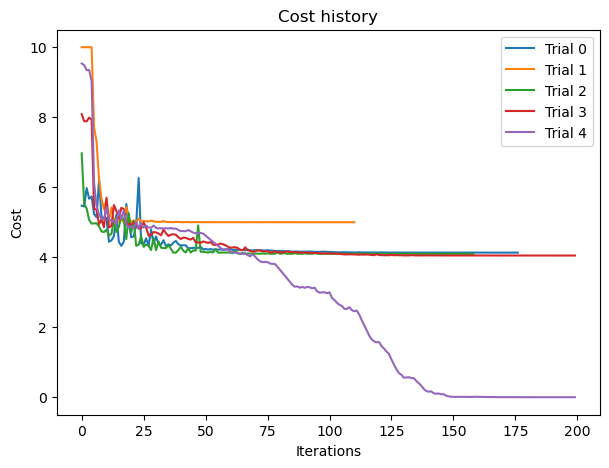

In [212]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost history')
ax.set_ylabel('Cost')
ax.set_xlabel('Iterations')
### Write your code below here ###
np.save('res_list.npy', res_list)

for it, cost_history in enumerate(cost_history_list):
    ax.plot(cost_history, label='Trial '+str(it))
    ax.legend()
### Don't change any code past this line ###    

<a id="exercise3"></a>
<div class="alert alert-block alert-success">

    
<b> Exercise 3:</b> 

In this exercise, you need to check which set of initial parameters yield the best convergence. For this, you need to define two functions that will be used throughout the Lab:

1. A function ```test_VQC```, which applies the circuit with optimal parameters to each of the birds in the data set and outputs the converged value of the cost function.
2. A function ```compute performance``` which outputs the total performance (P) for each set of optimal parameters, which is defined as 

$P = 100 - 100\cdot\sum_{i\in \text{birds}} \frac{\vert (\langle \psi_i(\theta_{opt}) \vert \hat{O} \vert \psi_i(\theta_{opt})\rangle - L_i\vert}{2^5}$.
 
</div>  

In [213]:
def test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm):
    
    """Return the performance of the classifier

    Parameters:
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation 
        
    Returns:
        list: List of test results
    """
    ### Write your code below here ###
    
    # # Initialize a callback dictionary
    # callback_dict = {
    #     "prev_vector": None,
    #     "iters": 0,
    #     "cost_history": [],
    # }

    # # Minimize the cost function using scipy
    # res = minimize(
    #     cost_func, 
    #     opt_params, 
    #     args=(list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict), 
    #     method="cobyla", # Classical optimizer
    #     options={'maxiter': 200}) # Maximum number of iterations

    results_test = []

    for amplitudes in list_coefficients:
        qc = QuantumCircuit(num_qubits)
        qc.initialize(amplitudes)
        classifier = qc.compose(ansatz)

        transpiled_classifier = pm.run(classifier)
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        job = estimator.run([pub])
        
        result = job.result()[0].data.evs
        results_test.append(abs(result))

        
    ### Don't change any code past this line ###                                 
    return results_test

In [214]:
def compute_performance(result_list, list_labels):
    
    """Return the performance of the classifier

    Parameters:
        result_list (list): List of results
        list_labels (list): List of labels
        
    Returns:
        float: Performance of the classifier
    """
    ### Write your code below here ###
    performance = 100
    for result, label in zip(result_list, list_labels):
        performance -= np.abs(abs(result) - label)/len(list_coefficients)*100
    ### Don't change any code past this line ###                                    
    return performance

Now lets visualize our results:

Performance for trial 0: 73.95241618496425
Performance for trial 1: 50.02019567746892
Performance for trial 2: 72.47668014983057
Performance for trial 3: 77.64307090635324
Performance for trial 4: 99.99876396470968


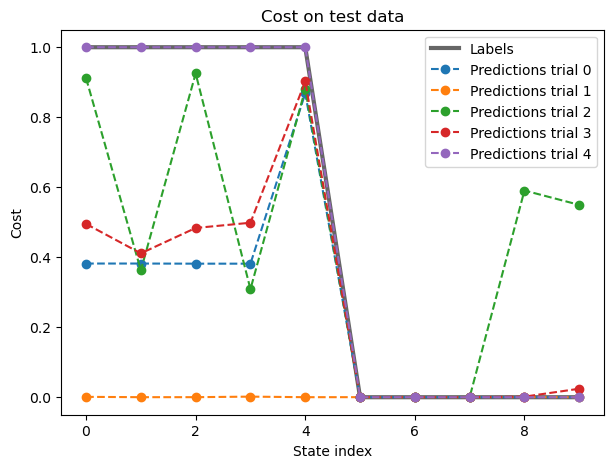

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

for index in range(len(res_list)):
    opt_params = res_list[index].x
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)
    print(f"Performance for trial {index}: {compute_performance(results_test, list_labels)}")
    ax.plot(results_test, 'o--', label='Predictions trial '+str(index))

ax.legend()

## Part 2: Test the VQC on quantum hardware

In this part of the Lab, we want to run our circuits on on real hardware! 

To make this possible, there are a few things that need to be modified. The main problem is that the circuit which we have been considering so far (amplitude embedding + ansatz) does not take into account the limitations of the hardware. In particular, ```qc.initialize``` is a general function that allows us to map **any** statevector state into our circuit. However, this comes at the expense of efficiency. Instead, we can look at the structure of our dataset to create a tailored mapping, which should allow us to reduce the circuit depth. Moreover, so far, we have been considering the ```RealAmplitudes```ansatz with all-to-all connectivity, which leads to big number of SWAP gates after transpiling to an actual device with a heavy-hex connectivity.

To show this, we start by checking what happens when we transpile the VQC that we have been using so far for a device with limited connectivity. We are going to create a simulator from real backend data using the ```AerSimulator``` to use as our device.


<a id="tips"></a>
<div class="alert alert-block alert-info">
    
<b> Tip:</b> 

Using ```AerSimulator.from_backend(backend)``` configures the simulator automatically to mimic an IBM Quantum backend. This means implementing the current noise model of that backend, as well as the same basis gates and coupling map. Another way of obtaining a simulator that mimics an IBM Quantum backend is to use the ```qiskit_ibm_runtime.fake_provider.FakeBackend()``` object. This also automatically creates a simulator with a similar configuration, but the noise model is not the current one.

For this part of the Lab, we recommend choosing an IBM Quantum backend that you have access to, since we will use these simulations as a guide to run the code on the real backend later on. Take into account that the properties of the devices can change a lot from one to another, so testing the VQC might not work so well for certain devices. We have used [Osaka](https://quantum.ibm.com/services/resources?system=ibm_osaka).

    
</div>

In [216]:
# Choose a real backend
service = QiskitRuntimeService(channel='ibm_quantum',)
#backend = service.least_busy(min_num_qubits=127)
backend = service.backend("ibm_sherbrooke")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

Let's start by checking the two-qubit depth of circuit we get by using ```qc.initialize``` after transpilation.

Depth of two-qubit gates:  31


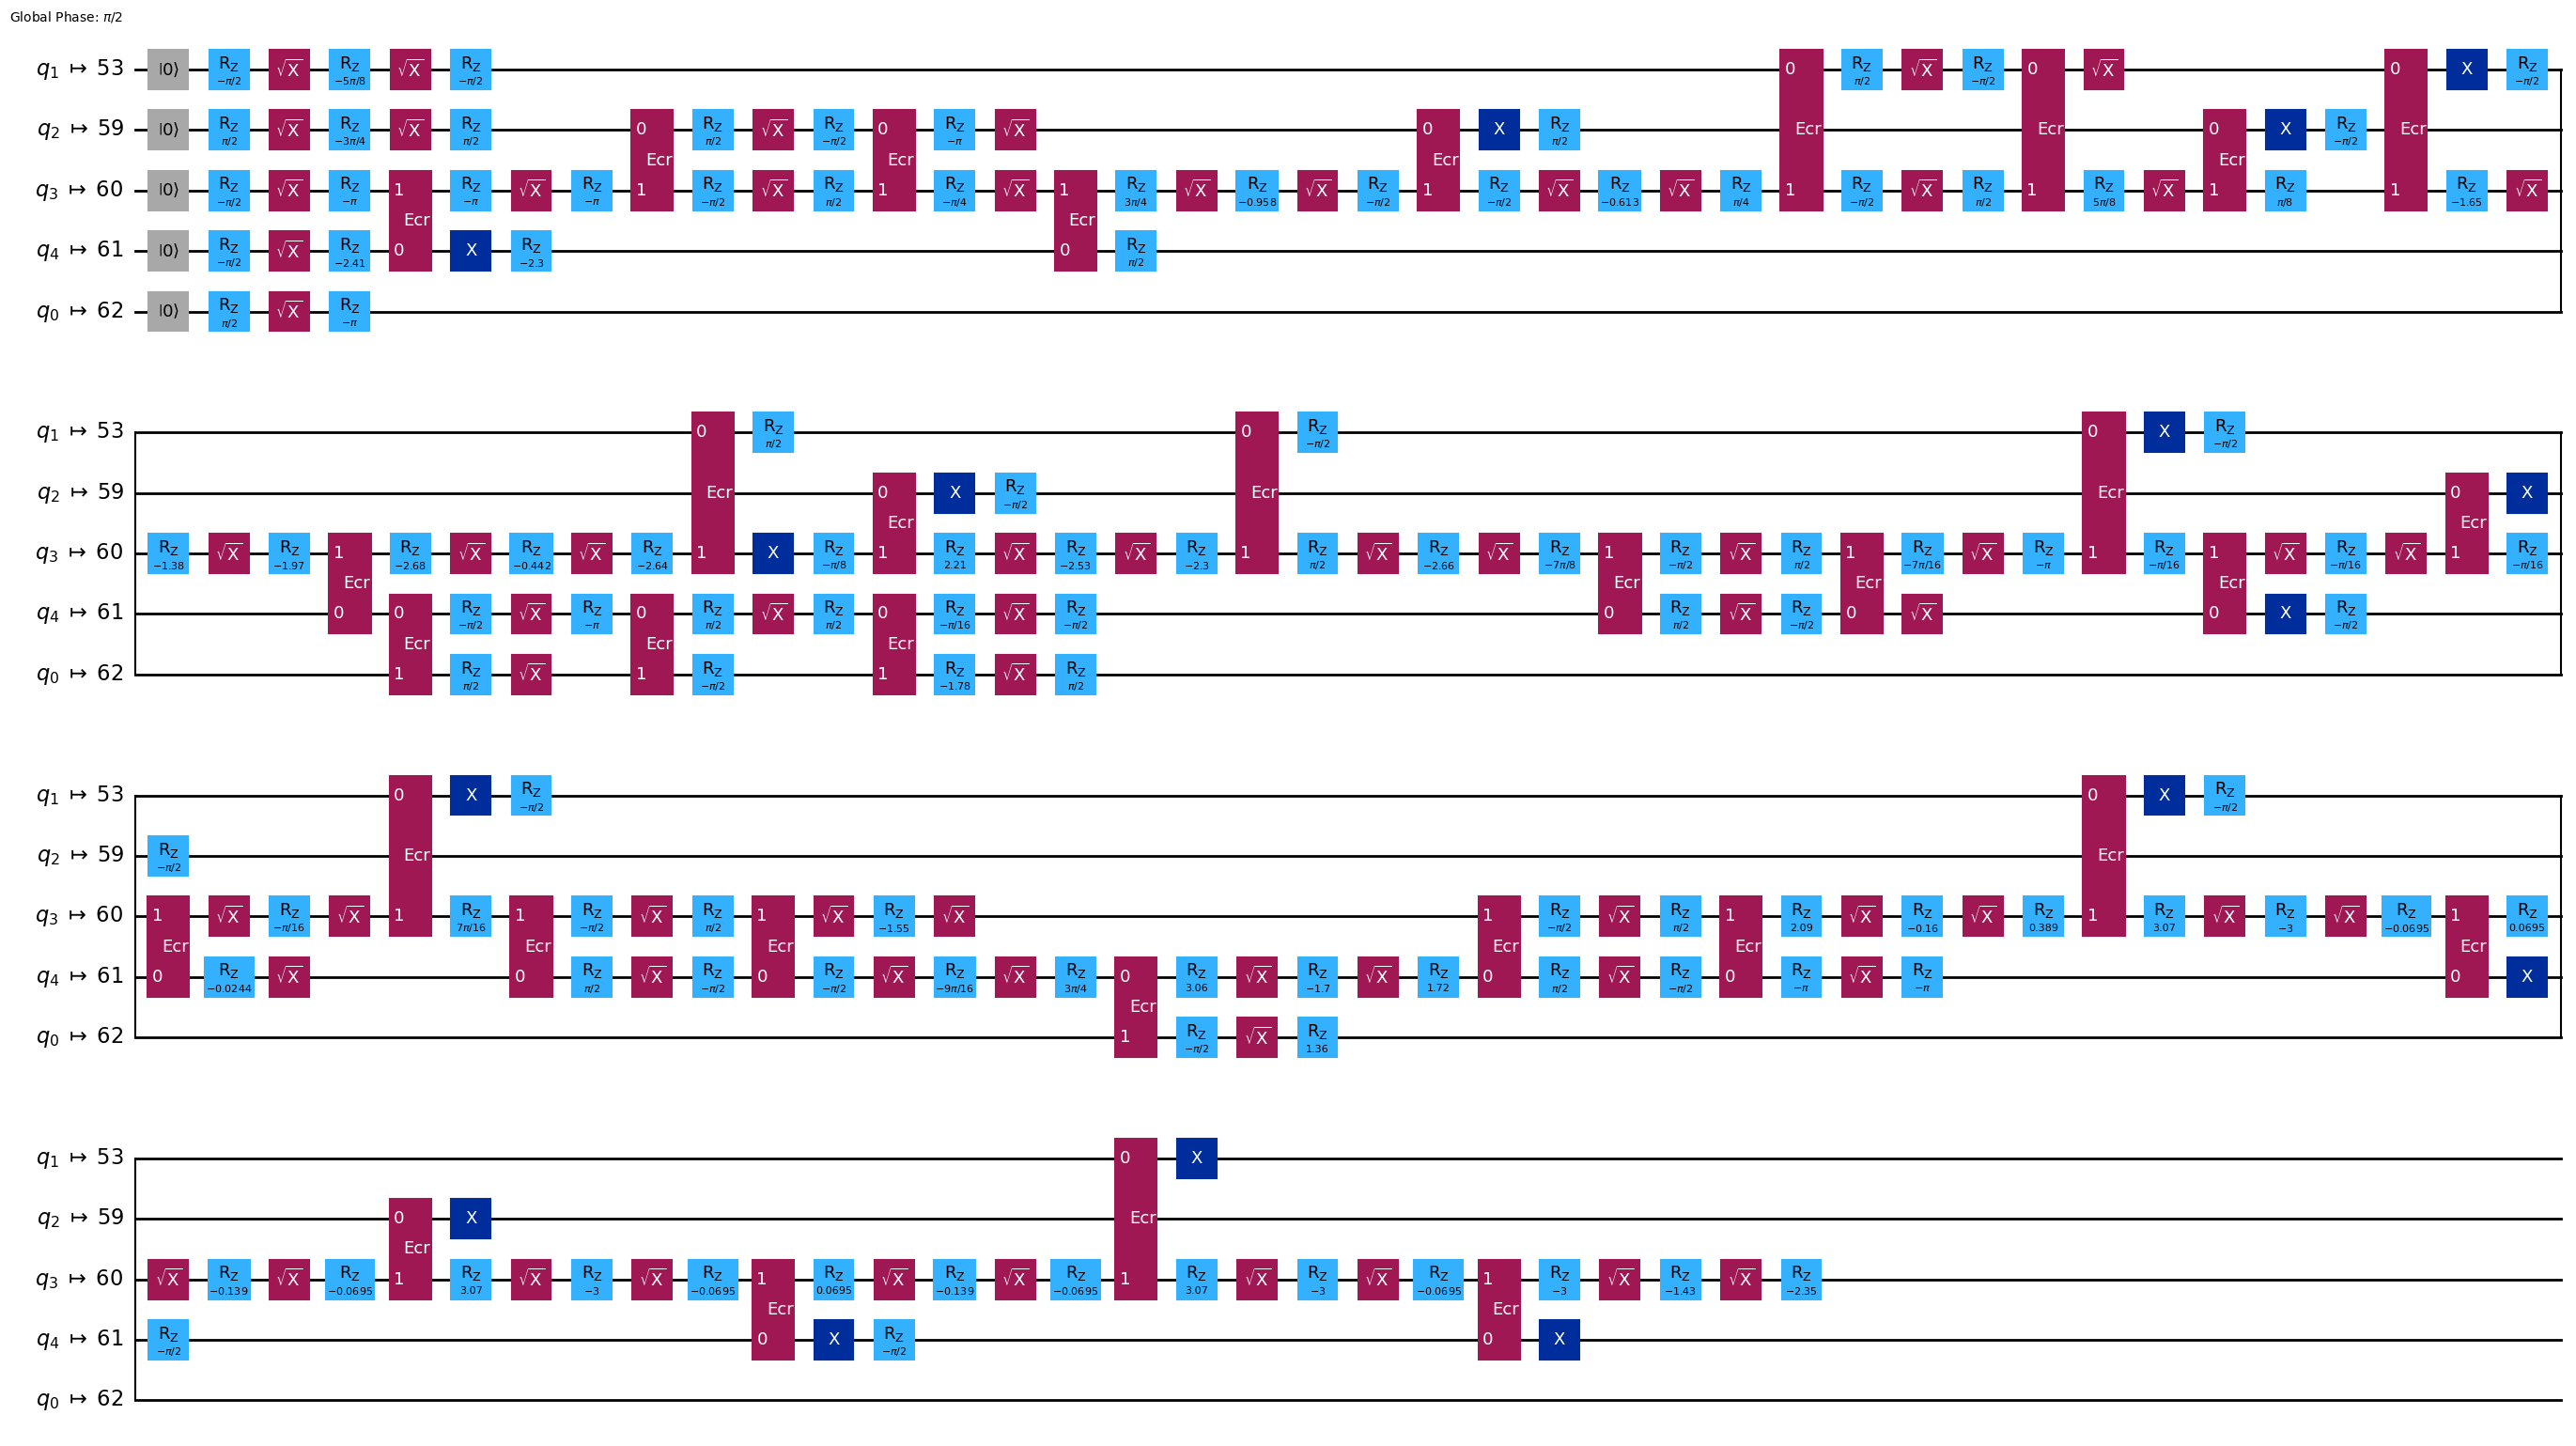

In [217]:
index_bird = 0 #you can check different birds by changing the index
qc = QuantumCircuit(num_qubits)
qc.initialize(list_coefficients[index_bird])
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", idle_wires=False, fold=40)

This circuit is too deep to be run on real quantum hardware! Let's try to find a different way to map the states of the dataset.

<a id="exercise5"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 4:</b> 

Create a function to map the states more efficiently. For this we need to look closer at the data set and understand how it was built. Whenever we want to run our code on the hardware, we always need to use the structure of our data and our problem wisely!

- **IBM Quantum birds** correspond to the first 5 entries of the dictionary, with indices $0$, $1$, $2$, $3$, $4$. Their states are creating by:
    - We start by generating a GHZ state starting using the function ```generate_GHZ```.
    - Then, we change the index to its binary representation with 5 digits. For example, bird number $2$ corresponds to the binary number $00010$. This means we need to add a bit flip on the second last qubit.
    - This leads to a final GHZ state which will be $\vert 00010 \rangle + \vert 11101 \rangle$ for the bird number $2$ or $\vert 00011 \rangle + \vert 11100 \rangle$ for the bird number $3$.

- **non-IBM Quantum birds** correspond to the last 5 entries of the dictionary, with indices $5$, $6$, $7$, $8$, $9$. Here, the state is simply the product state corresponding to the binary representation of the index, as indicated in the second step above.

</div> 

<a id="tips"></a>
<div class="alert alert-block alert-warning">
    
<b> Warning:</b> If you create any helper functions, make sure to place them inside of the ```amplitude_embedding``` function.
    
</div>

In [218]:
def amplitude_embedding(num_qubits, bird_index):
    """Create amplitude embedding circuit

    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
    def generate_GHZ(qc):
        qc.h(0)
        for i, j in zip(range(num_qubits-1), range(1,num_qubits)):
            qc.cx(i, j)
            
    ### Write your code below here ###
    qc = QuantumCircuit(num_qubits)

    if (bird_index < 5):
        generate_GHZ(qc)

    bin = format(bird_index, "0" + str(num_qubits) + "b")
    bin = bin[::-1]
    for i in range(0,num_qubits-1):
        if (bin[i] == "1"):
            qc.x(i)
    print(qc)
        
    ### Don't change any code past this line ###
    return qc

The cell below can be used to check if you are creating the correct states:

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
q_4: ─────
          


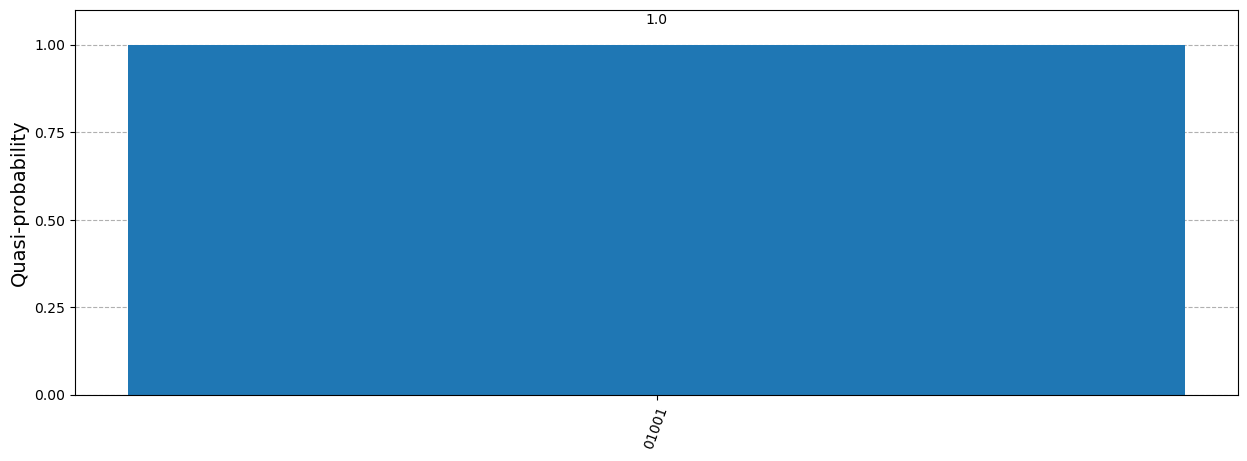

In [219]:
index_bird = 9 # You can check different birds by changing the index

# Build the amplitude embedding 
qc = amplitude_embedding(num_qubits, index_bird)
qc.measure_all()

# Define the backend and the pass manager
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuit = pm.run(qc)

# Define the sampler with the number of shots
sampler = Sampler(mode=aer_sim)
result = sampler.run([isa_circuit]).result()
samp_dist = result[0].data.meas.get_counts()
plot_distribution(samp_dist, figsize=(15, 5))

Now, let's check the depth of the new amplitude embedding circuit:

     ┌───┐                    
q_0: ┤ H ├──■─────────────────
     └───┘┌─┴─┐               
q_1: ─────┤ X ├──■────────────
          └───┘┌─┴─┐          
q_2: ──────────┤ X ├──■───────
               └───┘┌─┴─┐     
q_3: ───────────────┤ X ├──■──
                    └───┘┌─┴─┐
q_4: ────────────────────┤ X ├
                         └───┘
Depth of two-qubit gates:  4


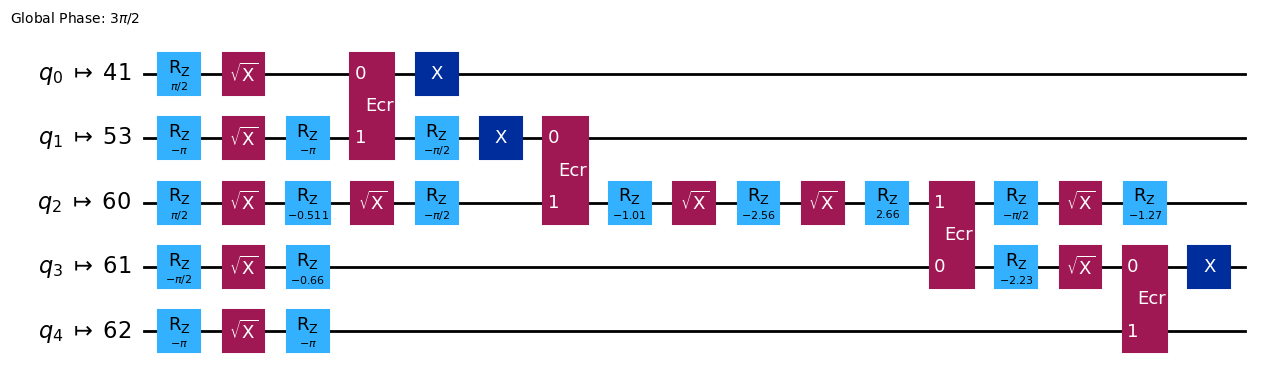

In [220]:
index_bird = 0 #You can check different birds by changing the index
qc = amplitude_embedding(num_qubits, index_bird)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

Now, let's check the transpiled version of the ```RealAmplitudes``` ansatz using full connectivity.

Depth of two-qubit gates:  18


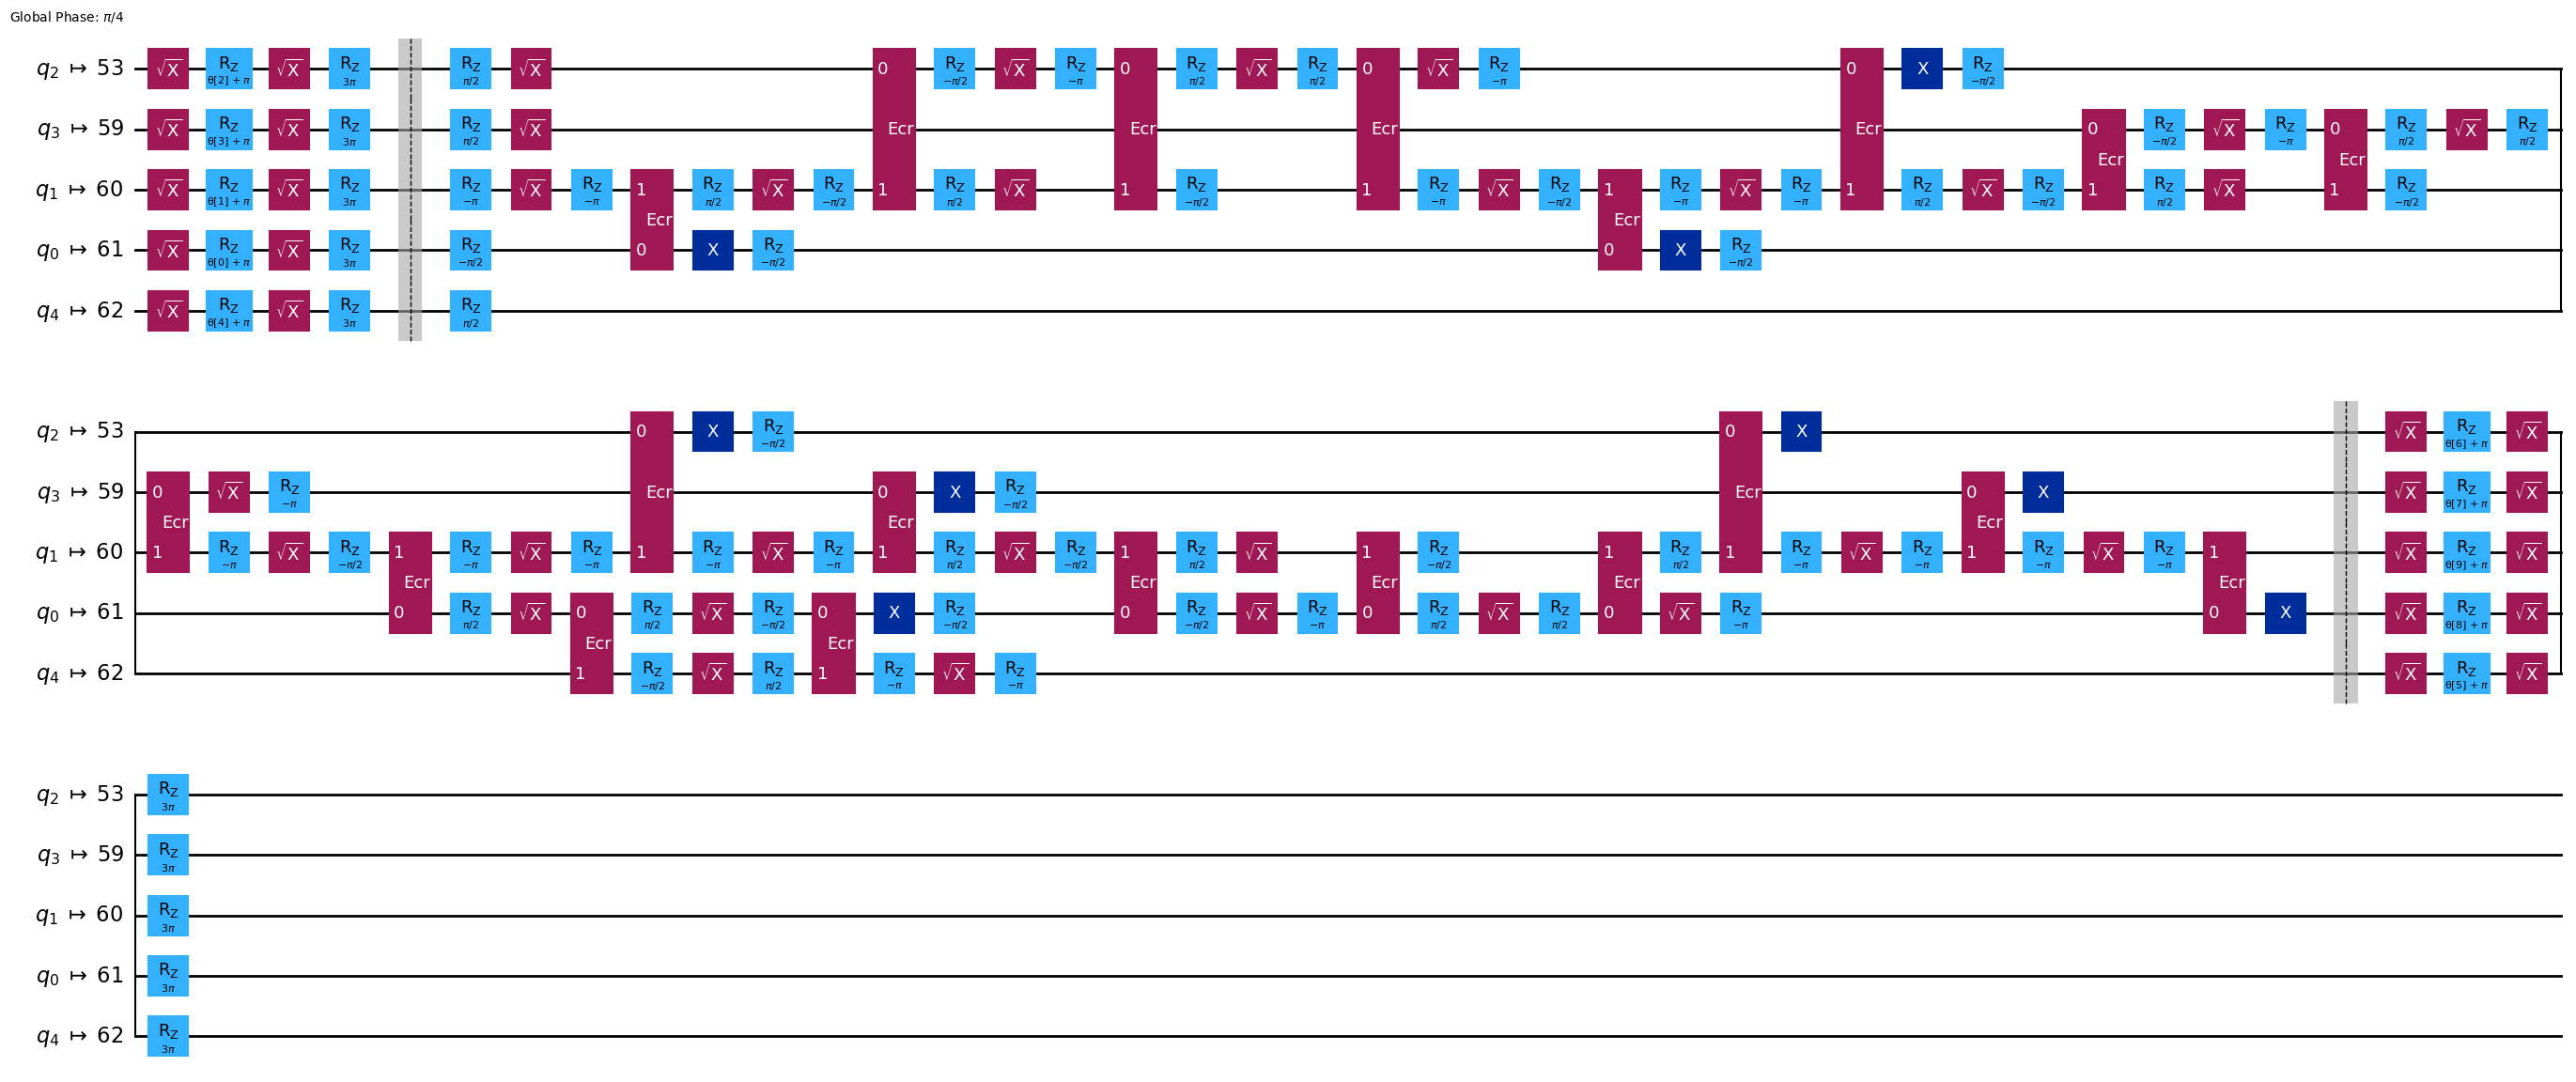

In [221]:
old_ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='full', insert_barriers=True)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_ansatz = pm.run(old_ansatz)

print('Depth of two-qubit gates: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))
transpiled_ansatz.draw(output="mpl", idle_wires=False, fold=40)

<a id="exercise5"></a>
<div class="alert alert-block alert-success">

<b> Exercise 5:</b> 

    
Change the connectivity to a _pairwise_ structure and check the depth of the circuit again. By how much was the depth reduced?

</div> 


Depth of two-qubit gates:  2


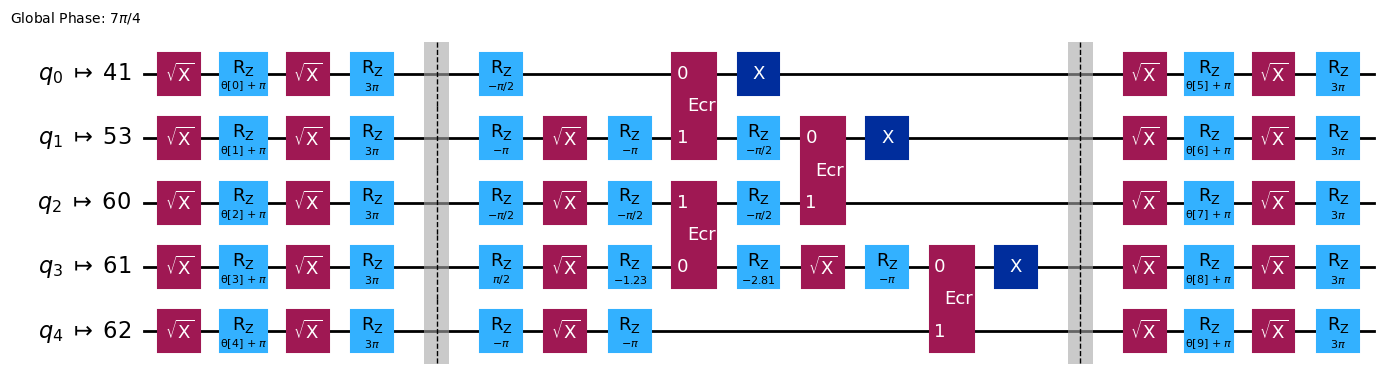

In [222]:
ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='pairwise', insert_barriers=True)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_ansatz = pm.run(ansatz)

print('Depth of two-qubit gates: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))
transpiled_ansatz.draw(output="mpl", fold=False, idle_wires=False)

Now, we can compare the total two-qubit gate depth of the old and the new VQC circuit by transpiling the composition of the amplitude embedding and the ansatz. 

In [223]:
old_mapping = QuantumCircuit(num_qubits)
old_mapping.initialize(list_coefficients[index_bird])
old_classifier = old_mapping.compose(old_ansatz)

new_mapping = amplitude_embedding(num_qubits, index_bird)
new_classifier = new_mapping.compose(ansatz)

pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
old_transpiled_classifier = pm.run(old_classifier)
new_transpiled_classifier = pm.run(new_classifier)

print('Old depth of two-qubit gates: ', old_transpiled_classifier.depth(lambda x: len(x.qubits) == 2))
print('Current depth of two-qubit gates: ', new_transpiled_classifier.depth(lambda x: len(x.qubits) == 2))

     ┌───┐                    
q_0: ┤ H ├──■─────────────────
     └───┘┌─┴─┐               
q_1: ─────┤ X ├──■────────────
          └───┘┌─┴─┐          
q_2: ──────────┤ X ├──■───────
               └───┘┌─┴─┐     
q_3: ───────────────┤ X ├──■──
                    └───┘┌─┴─┐
q_4: ────────────────────┤ X ├
                         └───┘
Old depth of two-qubit gates:  57
Current depth of two-qubit gates:  6


With the new ansatz we have reduced the depth by a factor of 10! This shows why the transpiler is such an important tool, not only does it help you reduce circuit depths, but it helps you check how different parts of quantum circuits together work on a real device and helps you finding better circuits with lower depth.
This means that we would be ready to test our VQC on quantum hardware.

Let's test this shallow circuit with a simulator to see how the results would look.

In [224]:
def test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm):
    
    """Return the performance of the classifier

    Parameters:
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation 
        
    Returns:
        results_test (list): List of test results
    """
    ### Write your code below here ###
    results_test = []
    for bird, label in enumerate(list_labels):
        qc = amplitude_embedding(num_qubits, bird)
        classifier = qc.compose(ansatz)
        transpiled_classifier = pm.run(classifier)
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        job = estimator.run([pub])
        result = job.result()[0].data.evs
        results_test.append(abs(result))
    ### Don't change any code past this line ###                       
    return results_test

Let's test the shallow VQC on the fake backend! We have already trained the new VQC for you, so you can use the optimal parameters given in ```opt_params_shallow_VQC.npy```. 

     ┌───┐                    
q_0: ┤ H ├──■─────────────────
     └───┘┌─┴─┐               
q_1: ─────┤ X ├──■────────────
          └───┘┌─┴─┐          
q_2: ──────────┤ X ├──■───────
               └───┘┌─┴─┐     
q_3: ───────────────┤ X ├──■──
                    └───┘┌─┴─┐
q_4: ────────────────────┤ X ├
                         └───┘
     ┌───┐     ┌───┐          
q_0: ┤ H ├──■──┤ X ├──────────
     └───┘┌─┴─┐└───┘          
q_1: ─────┤ X ├──■────────────
          └───┘┌─┴─┐          
q_2: ──────────┤ X ├──■───────
               └───┘┌─┴─┐     
q_3: ───────────────┤ X ├──■──
                    └───┘┌─┴─┐
q_4: ────────────────────┤ X ├
                         └───┘
     ┌───┐                    
q_0: ┤ H ├──■─────────────────
     └───┘┌─┴─┐     ┌───┐     
q_1: ─────┤ X ├──■──┤ X ├─────
          └───┘┌─┴─┐└───┘     
q_2: ──────────┤ X ├──■───────
               └───┘┌─┴─┐     
q_3: ───────────────┤ X ├──■──
                    └───┘┌─┴─┐
q_4: ────────────────────┤ X ├
        

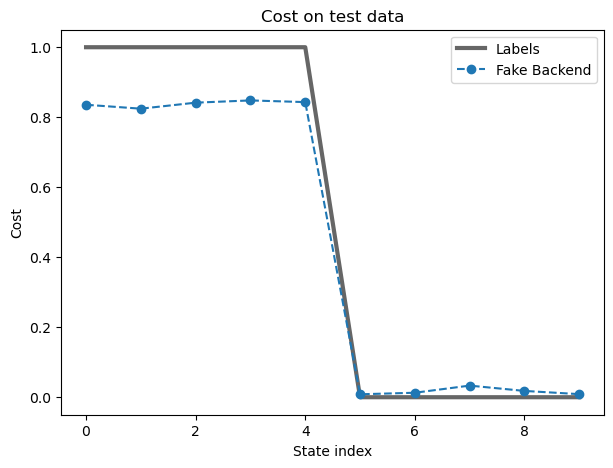

In [225]:
estimator = Estimator(mode=fake_backend)
estimator.options.default_shots = 5000
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)

opt_params = np.load('opt_params_shallow_VQC.npy') # Load optimal parameters
results_test = test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm)

print(f"Performance: {compute_performance(results_test, list_labels)}")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')
ax.plot(results_test, 'o--', label='Fake Backend')
ax.legend()

Note that this simulation should be similar to what you would obtain on the real device that you chose before. We can see that the effect of noise lowers the performance, but we still obtain reliable results.

## Part 3: Scaling to 50 qubits

### Step 1: Find a way to efficiently create GHZ states on 50 qubits

We start by recovering our amplitude embedding function above to make it easier to compare:

In [226]:

def old_amplitude_embedding(num_qubits, bird_index):
    """Create amplitude embedding circuit

    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
    def generate_GHZ(qc):
        qc.h(0)
        for i, j in zip(range(num_qubits-1), range(1,num_qubits)):
            qc.cx(i, j)
            
    ### Write your code below here ###

    def generate_binary(qc, number):
        position=0
        bit=1
        while number >= bit:
            if number & bit:
                qc.x(position)
            bit <<= 1
            position=position+1
                

    qc = QuantumCircuit(num_qubits)
    if bird_index < 5:
        generate_GHZ(qc)
    generate_binary(qc, bird_index)
    
    ### Don't change any code past this line ###
    return qc


The generation of the GHZ state in the previous `old_amplitude_embedding` function scales linearly with the number of qubits. You can check it using the following cells from Lab 4:

Depth of two-qubit gates:  49


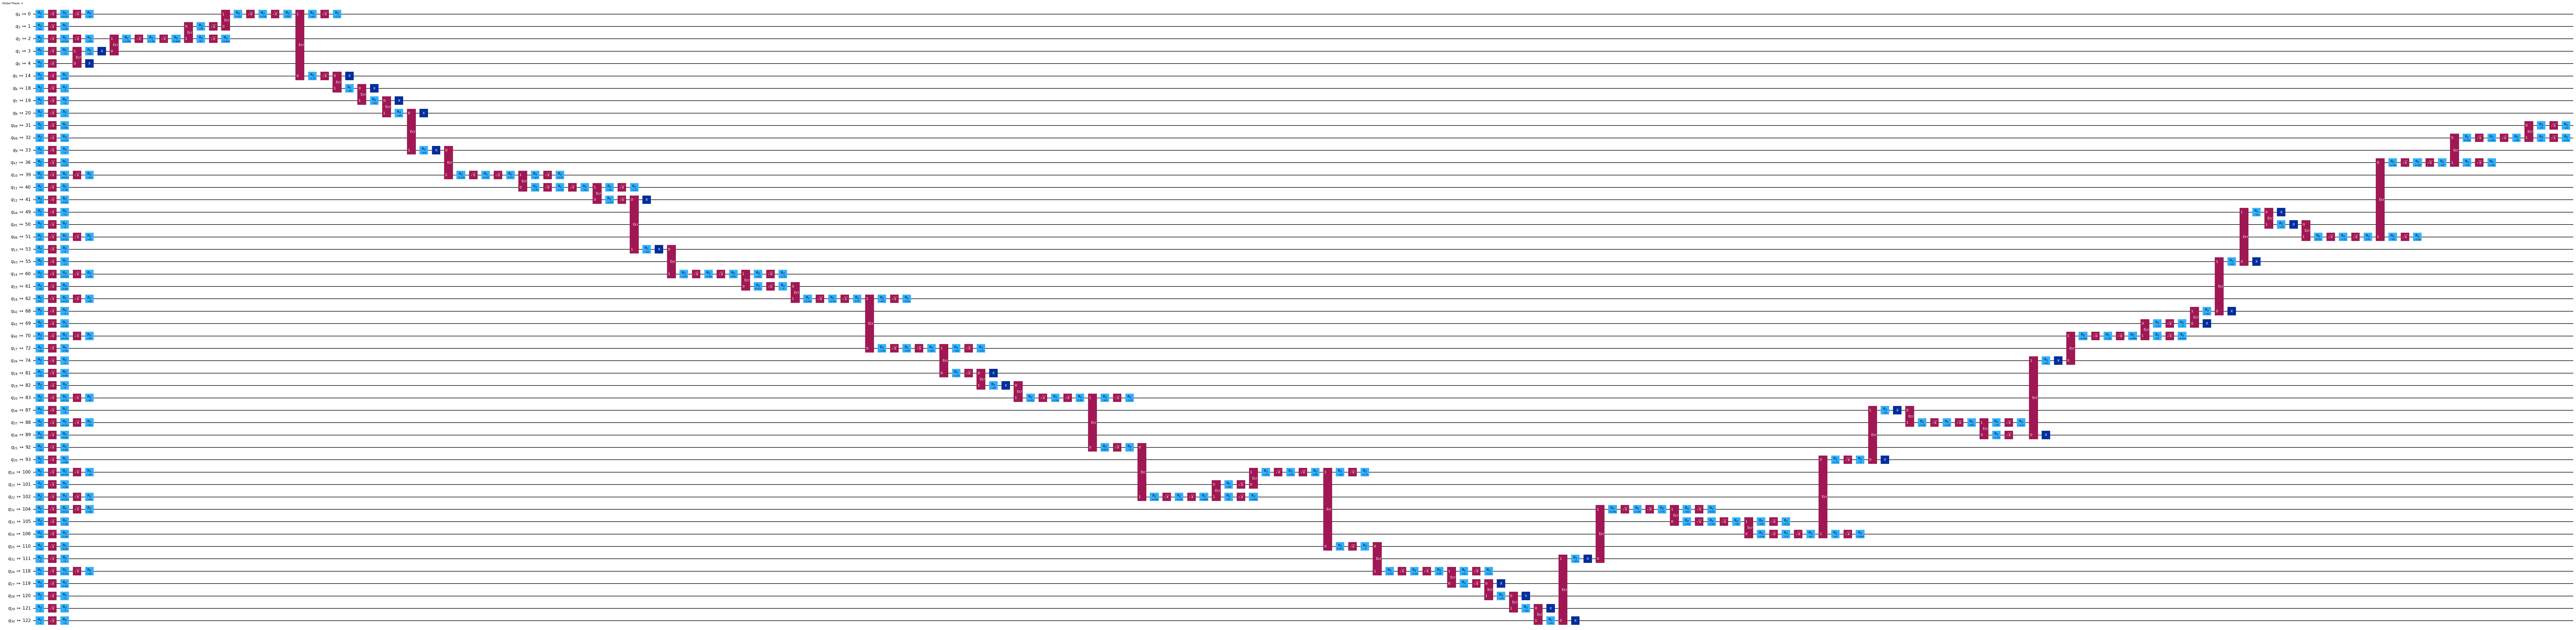

In [227]:

num_qubits = 50

# Choose a real backend
#service = QiskitRuntimeService() # we did use a service before 
#backend = service.least_busy(min_num_qubits=127)

# Define a fake backend with the same properties as the real backend
#fake_backend = AerSimulator.from_backend(backend)

index_bird = 0 # You can check different birds by changing the index
qc = old_amplitude_embedding(num_qubits, index_bird)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

If the two-qubit depth is of the order of 50 it is too large!! 

<a id="step1"></a>
<div class="alert alert-block alert-success">

<b> Exercise 6:</b> 


Find a way to efficiently encode the GHZ states in a large circuit and reduce the circuit two-qubit depth to 13 or less. This [blog post](https://dahalegopal27.medium.com/greetings-from-the-ibm-spring-challenge-map-of-127-qubits-ce08817176a7) can serve as inspiration!

The underlying concept leverages the symmetry in entangled qubits. Once two qubits are entangled, their symmetrical properties can be utilized to entangle additional qubits. This cascading entanglement process can be very efficient if the quantum system allows for all-to-all connectivity; in such a scenario, creating a GHZ state involving 
$𝑁$ qubits requires only an asymptotic complexity of $(O(\log(N)))$ steps._ 

However, in systems with heavy hexagonal (heavy hex) connectivity, the process is less efficient, and requires $(O(\sqrt{N}))$ steps to achieve the same._

</div> 

<a id="tips"></a>
<div class="alert alert-block alert-info">
    
<b> Tip:</b> 

Think about what you learned in the last exercise and the example which was used there! 
We suggest to try it on your own, however, if that takes to long, feel free to use the example from the last exercise directly. 

    
</div>

In [228]:
import rustworkx as rx
from rustworkx.visit import BFSVisitor
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

source_list=  []
target_list=[]

# The layer list will be used later. 
layer_list=[1, 2, 2, 3, 3, 1, 1, 1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3]

coupling_map = fake_backend.coupling_map

def new_amplitude_embedding(num_qubits, bird_index):
    """Create efficient amplitude embedding circuit
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
            
    ### Write your code below here ###
    def generate_efficient_GHZ(qc, qr):
        class TreeEdgesRecorder(BFSVisitor):
            def __init__(self):
                self.edges = []

            def tree_edge(self, edge):
                self.edges.append(edge)

        # Create a graph from the layout
        G = rx.PyGraph()
        indices = G.add_nodes_from(range(num_qubits))
        for edge in edges:
            if edge[0] < num_qubits and edge[1] < num_qubits:
                G.add_edge(edge[0], edge[1], None)

        source_vertex = int(num_qubits/2)  # Root node
        vis = TreeEdgesRecorder()
        rx.bfs_search(G, [source_vertex], vis)  # Run the BFS algorithm
        # Start with superposition
        # qc.h(0)
        # Apply entangling layers
        # max_layer = max(layer_list)
        # for layer in range(1, max_layer + 1):
        #     for s, t, l in zip(source_list, target_list, layer_list):
        #         if l == layer:
        #             qc.cx(s, t)

        # Create GHZ-State
        qc.h(qr[source_vertex])
        for edge in vis.edges:
            u, v, _ = edge
            qc.cx(qr[u], qr[v])
    
    def generate_binary(qc, number):
        position = 0
        bit = 1
        while number >= bit:
            if number & bit:
                qc.x(position)
            bit <<= 1
            position += 1


    edges = list(coupling_map.get_edges())
    for edge in edges:
        u, v = edge
        source_list.append(u)
        target_list.append(v)

    # Preparing registers and Quantum Circuit
    qr = QuantumRegister(num_qubits)
    #cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr)

    if bird_index < 5:
        generate_efficient_GHZ(qc, qr)
    generate_binary(qc, bird_index)
    
    ### Don't change any code past this line ###
    return qc

The `matrix_product_state` [MPS](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html) method is more efficient than a full statevector simulation because it reduces the computational and memory demands. While the full statevector simulation requires exponential resources in relation to the number of qubits, MPS uses a tensor-based representation that scales more favorably, particularly in systems with low entanglement. This allows MPS to perform operations faster and with less memory in many scenarios, making it particularly effective for circuits that aren't heavily entangled and are low in depth. 

**You can find more about this in the documentation link [here.](https://qiskit.github.io/qiskit-aer/tutorials/7_matrix_product_state_method.html#id1)**

**You can use the following cell below to check that you are mapping the right states.**


<div class="alert alert-block alert-danger">

**Please note:** Please make sure your `GHZ` is constructed correct using the code block below. Try experimenting with different values of index and ensure you get a `GHZ` state.

</div>

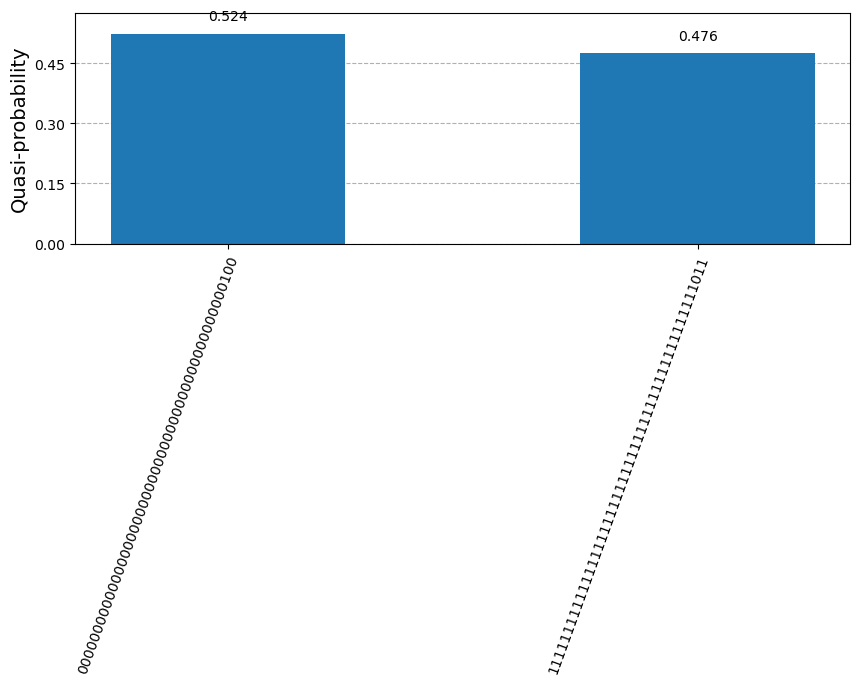

In [229]:
num_qubits = 50
index = 4 # Change to different values for testing
qc = new_amplitude_embedding(num_qubits, index)
qc.measure_all()

# Define the backend and the pass manager
aer_sim = AerSimulator(method='matrix_product_state')
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuit = pm.run(qc)

# Define the sampler with the number of shots
sampler = Sampler(mode=aer_sim)
result = sampler.run([isa_circuit]).result()
samp_dist = result[0].data.meas.get_counts()
plot_distribution(samp_dist, figsize=(10, 3))

And you can check the new qubit two-qubit depth here:

**Play around with the optimization level.** We can see that with optimization level 3 it will find the optimal layout and because of that the circuit becomes A LOT less deep. This shows how important transpilation is. And what difference it can make!

In [230]:
num_qubits = 50

# Choose a real backend
# service = QiskitRuntimeService() 
# backend = service.least_busy(min_num_qubits=127)

# Define a fake backend with the same properties as the real backend
#fake_backend = AerSimulator.from_backend(backend)

index_bird = 0 #You can check different birds by changing the index
qc = new_amplitude_embedding(num_qubits, index_bird)
pm = generate_preset_pass_manager(optimization_level=1, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
#Draw the circuit only when the depth is low enough!!
#transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

Depth of two-qubit gates:  11


### Step 2: Adapt the `RealAmplitudes` ansatz to the new mapping

In [231]:
def generate_old_ansatz(qubits):
    qc = RealAmplitudes(qubits, reps=1, entanglement='pairwise')
    return qc

num_qubits = 50

# Choose a real backend
# service = QiskitRuntimeService()
# backend = service.least_busy(min_num_qubits=127)

# Define a fake backend with the same properties as the real backend
#fake_backend = AerSimulator.from_backend(backend)

index_bird = 0 # You can check different birds by changing the index
qc = new_amplitude_embedding(num_qubits, index_bird)
ansatz = generate_old_ansatz(num_qubits)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc.compose(ansatz))
print('Depth new mapping + old ansatz: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
# transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

Depth new mapping + old ansatz:  65


<a id="exercise3"></a>
<div class="alert alert-block alert-success">

<b> Exercise 7:</b> 


Change the entanglement structure of the `RealAmplitudes` ansatz so that the total two-qubit depth of the circuit (embedding + ansatz) is reduced to **less than `15` layers**. 

*Hint: Consider the mapping that you have used for the `GHZ` state for the heavy hex lattice and try to entangle the qubits to the neighbouring ones if possible, with only 3 alternating layers.*

</div>  

<a id="tips"></a>
<div class="alert alert-block alert-info">
    
<b> Tip:</b> 

Look at the connectivity of the graph (if you used a similar method as in the last exercise you can look at the layout there). In addition the layer list provided can help. (The provided layer list is made for the example we used in last exercise, so if you found your own way to construct a ghzit may look slightly different. But it should still give a hint on how to construct the ansatz.)

</div>

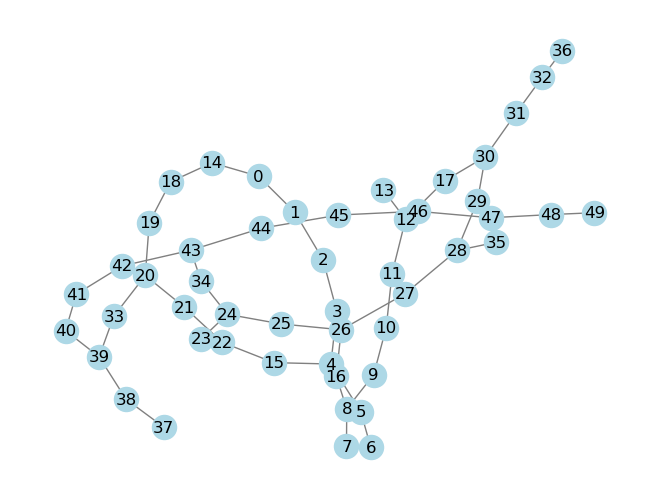

In [232]:
import networkx as nx

coupling_map = fake_backend.coupling_map
edges = list(coupling_map.get_edges())
for edge in edges:
    u, v = edge
    source_list.append(u)
    target_list.append(v)

G = rx.PyGraph()
indices = G.add_nodes_from(range(num_qubits))
for edge in edges:
    if edge[0] < num_qubits and edge[1] < num_qubits:
        G.add_edge(edge[0], edge[1], None)

edge_list = [
    (G[x[0]], G[x[1]])
    for x in G.edge_list()
]
nx_graph = nx.Graph(edge_list)

nx.draw(nx_graph, with_labels=True, node_color='lightblue', edge_color='gray')

In [233]:
def build_layers(coupling_map, num_qubits):
    """
    Build disjoint CNOT layers from the given coupling map.

    Args:
        coupling_map (list): List of [source, target] CNOT pairs.

    Returns:
        layers (list of lists): List of layers, each layer is a list of [source, target] pairs.
    """
    
    edges = list(coupling_map.get_edges())
    remaining_cnots = []
    for edge in edges:
        if edge[0] < num_qubits and edge[1] < num_qubits:
            remaining_cnots.append(edge)
    layers = []

    while remaining_cnots:
        current_layer = []
        used_qubits = set()

        # Try to fit as many disjoint CNOTs into this layer
        for cnot in remaining_cnots:
            src, tgt = cnot
            if src not in used_qubits and tgt not in used_qubits:
                current_layer.append(cnot)
                used_qubits.update([src, tgt])

        for cnot in current_layer:
            remaining_cnots.remove(cnot)

        layers.append(current_layer)

    return layers


def get_lists(layers):

    source_list = []
    target_list = []
    layer_list = []

    for layer in layers:
        for edge in layer:
            source_list.append(edge[0])
            target_list.append(edge[1])
            layer_list.append(layers.index(layer) + 1)

    return source_list,target_list,layer_list

In [ ]:
#Not using this
layer_list=[1, 2, 2, 3, 3, 1, 1, 1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3]

edges = list(fake_backend.coupling_map.get_edges())
source_list = [pair[0] for pair in edges[:len(layer_list)]]
target_list = [pair[1] for pair in edges[:len(layer_list)]]

layer1 = [[s, t] for s, t, l in zip(source_list, target_list, layer_list) if l == 1]
layer2 = [[s, t] for s, t, l in zip(source_list, target_list, layer_list) if l == 2]
layer3 = [[s, t] for s, t, l in zip(source_list, target_list, layer_list) if l == 3]

entanglement_pattern = [layer1, layer2, layer3]
print(entanglement_pattern)

[[[1, 0], [5, 4], [6, 5], [7, 6], [7, 8], [19, 20], [20, 33], [21, 20], [21, 22], [22, 15], [23, 22], [23, 24], [25, 24]], [[1, 2], [3, 2], [8, 9], [10, 9], [10, 11], [11, 12], [26, 16], [26, 25], [26, 27], [28, 27], [29, 28], [29, 30], [31, 30], [31, 32], [32, 36], [33, 39], [34, 24]], [[4, 3], [4, 15], [12, 13], [14, 0], [14, 18], [16, 8], [17, 12], [17, 30], [18, 19], [35, 28], [35, 47], [36, 51], [37, 38], [38, 39], [40, 39], [41, 40], [41, 53], [42, 41], [43, 34], [43, 42], [43, 44]]]


In [235]:
# Build layer_list based on backend coupling map
layers = build_layers(coupling_map, num_qubits)
source_list, target_list, layer_list = get_lists(layers)
print(layer_list)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:
def generate_ansatz(num_qubits):
    """Generate a `RealAmplitudes` ansatz where all qubits are entangled with each other 
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
    
    Returns:
        qc (QuantumCircuit): Quantum circuit with the generated ansatz
    """
    ### Write your code below here ###

    coupling_map = backend.coupling_map
    entanglement_pattern = build_layers(coupling_map, num_qubits)

    qc = QuantumCircuit(num_qubits)

    ansatz = RealAmplitudes(num_qubits=num_qubits,
                        reps=1,  
                        entanglement=entanglement_pattern,
                        insert_barriers=False)
    
    qc.compose(ansatz, inplace=True)
    
    ### Don't change any code past this line ###  
    return qc

##### Run this cell to check the total two-qubit depth

In [243]:
index_bird = 0 # You can check different birds by changing the index
new_mapping_qc = new_amplitude_embedding(num_qubits, index_bird)
ansatz = generate_ansatz(num_qubits)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(new_mapping_qc.compose(ansatz))
print('Depth new mapping + new ansatz: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
# transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

Depth new mapping + new ansatz:  12


### Step 3: Check the optimal parameters using the `AerSimulator`

Now we need to generalize the optimal parameters for a 50 qubits VQC.

<a id="task1"></a>
<div class="alert alert-block alert-success">

**Task:** The optimal parameters array should have $\pi$ in the first rotation of `RealAmplitudes` for the qubits that are used to entangle other qubits and zero everywhere else. The code provided here can be used, just **be sure to adapt it if needed!**


</div>  

In [244]:
# ADAPT THIS CODE TO MATCH YOUR ANSATZ!

#source_list= [1 , 1 , 2 , 2 , 3 , 3 , 4 , 5 ,  6,  7,  8,  9, 10,  8,  9, 10, 11, 12, 13, 14, 11, 15, 16, 17, 18, 19, 20, 21, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 38, 39, 40, 31, 33, 34, 35, 36, 37, 23, 25, 26]

def generalize_optimal_params(num_qubits, ansatz, source_list):
    """Generate a `list of optimal parameters for N qubits 
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        ansatz (QuantumCircuit): Ansatz for our VQC
        source_list (list): List of qubits used as source to entangle other qubits
    
    Returns:
        opt_params (list): List of optimal parameters generated for N qubits
    """
    
    opt_params = np.zeros(ansatz.num_parameters)
    for i in range(ansatz.num_parameters//2):
        if i in source_list:
            opt_params[i] = np.pi

    return opt_params

<a id="Task2"></a>
<div class="alert alert-block alert-success">

**Task:** Let's recover the `compute_performance` and the `test_shallow_VQC` functions from above, both to test with the `AerSimulator` and for a `QPU`. Modify the cost function by including a `-1` factor, as the parameters previously calculated are optimized for the inverse of the cost function. 

**Please note:** You need to use the `new_amplitude_embedding` and the `generate_ansatz` functions which you created above so you may need to adapt the code (if you used different naes etc.)

</div>  

In [245]:
# MAKE SURE TO ADAPT THIS CODE IF NEEDED

def test_shallow_VQC_QPU(num_qubits, list_labels, obs, opt_params, options, backend):
    """Tests the shallow VQC on a QPU
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        list_labels (list): List of labels
        obs: (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Options for Estimator primitive
        backend (Backend): Real backend from IBM Quantum to run the job
    
    Returns:
        job_id (str): Job ID for Quantum job
    """

    ### Write your code below here ###
    results_test = []
    estimator = Estimator(mode=backend, options=options)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

    pubs = []
    for bird, label in enumerate(list_labels):
        new_mapping_qc = new_amplitude_embedding(num_qubits, bird)
        #ansatz = generate_old_ansatz(num_qubits)
        ansatz = generate_ansatz(num_qubits)
        classifier = new_mapping_qc.compose(ansatz)
        transpiled_classifier = pm.run(classifier)
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        pubs.append(pub)

    job = estimator.run(pubs)
    job_id = job.job_id()
    print(f"Job ID: {job_id}")
    print(f"Status: {job.status()}")
    ### Don't change any code past this line ###                         
                        
    return job_id

def retrieve_job(job_id):
    """Retrieve test results from job id
    Parameters: 
        job_id (str): Job ID
    Returns:
        results_test (list): List of test results
        errors_test (list): List of test errors
    """
    
    job = service.job(job_id)
    results_test = []
    errors_test = []
    for result in job.result():
        results_test.append(abs(abs(result.data.evs)-1)) #COST FUNCTION HAS A -1 NOW!!!
        errors_test.append(abs(result.data.stds))
        
    return results_test, errors_test

def test_shallow_VQC_CPU(num_qubits, list_labels, obs, opt_params, options, backend):
    """Tests the shallow VQC on a QPU
    
    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        list_labels (list): List of labels
        obs: (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Options for Estimator primitive
        backend (Backend): AerSimulator backend to run the job
    
    Returns:
        results_test (list): List of test results
    """
    
    results_test = []
    ### Write your code below here ###
    estimator = Estimator(mode=backend)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    
    results_test = []
    for bird, label in enumerate(list_labels):
        new_mapping_qc = new_amplitude_embedding(num_qubits, bird)
        #ansatz = generate_old_ansatz(num_qubits)
        ansatz = generate_ansatz(num_qubits)
        classifier = new_mapping_qc.compose(ansatz)
        transpiled_classifier = pm.run(classifier)
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        job = estimator.run([pub])
        ### Don't change any code past this line ### 
        result = job.result()[0].data.evs
        results_test.append(abs(abs(result)-1)) # COST FUNCTION NOW HAS A -1!!!  
                                           
    return results_test

def compute_performance(result_list, list_labels):
    """Return the performance of the classifier

    Parameters:
        result_list (list): List of results
        list_labels (list): List of labels
        
    Returns:
        performance (float): Performance of the classifier
    """
    ### Write your code below here ###
    performance = 100
    for result, label in zip(result_list, list_labels):
        performance -= np.abs(abs(result) - label)/len(list_labels)*100
    ### Don't change any code past this line ###                                    
    return performance

Now we are ready to check if everything works using MPS (tensor networks). This is just to check the circuit and not to benchmark it, hence we are not transpiling the circuit nor applying any noise models.

Performance for resilience 0: 50.0


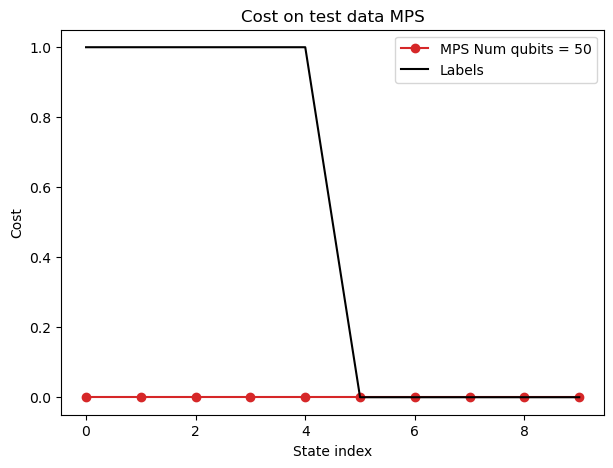

In [246]:
num_qubits = 50

aer_sim = AerSimulator(method='matrix_product_state')
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuit = pm.run(new_mapping_qc)

list_labels = np.append(np.ones(5), np.zeros(5))
obs = SparsePauliOp("Z"*num_qubits)
opt_params = generalize_optimal_params(num_qubits, generate_ansatz(num_qubits), source_list)
options = EstimatorOptions()

results_test_aer_sim = test_shallow_VQC_CPU(num_qubits, list_labels, obs, opt_params, options, aer_sim)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data MPS')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
print(f"Performance for resilience 0: {compute_performance(results_test_aer_sim, list_labels)}")
ax.plot(results_test_aer_sim, 'o-', color='tab:red', label='MPS Num qubits = ' + str(num_qubits))
ax.plot(list_labels, 'k-', label='Labels')
ax.legend()

### Final step: Testing a 50 qubit VQC on a quantum device (!)

At this point, you should be all set to run your VQC on a real device!  Lets start by choosing our device. For this part of the Lab, we recommend choosing an IBM Quantum backend that you have access to, since we will use these simulations as a guide to run the code on the real backend later on. Take into account that the properties of the devices can change a lot from one to another, so testing the VQC might not work so well for certain devices. We have used [ibm_sherbrooke](https://quantum.ibm.com/services/resources?system=ibm_sherbrooke). 

You can find the list of systems you have access to on [the Systems tab](https://quantum.ibm.com/services/resources?resourceType=current-instance&order=queue%20ASC&view=table) on IBM Quantum platform or run the following code:

```python
    from qiskit_ibm_runtime import QiskitRuntimeService

    service = QiskitRuntimeService()
    # list all available systems
    service.backends()
    # get the least busy system
    backend = service.least_busy()
```


<div class="alert alert-block alert-danger">

**Please note:** Please perform the checks above before running it on the real device to ensure you make the best use of your QPU time.

</div>

In [247]:
service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")

Let us specify options for our real system run. You can **test different error mitigation settings** to see what effects they have on the result. 

More detais about how to configure `options` for error mitigation with for Qiskit runtime can be found in [this tutorial](https://learning.quantum.ibm.com/tutorial/combine-error-mitigation-options-with-the-estimator-primitive) as well as in [the documentation](https://docs.quantum.ibm.com/run/configure-error-mitigation).




<div class="alert alert-block alert-danger">

**Please note:** For `10000` shots the estimated runtime is around 1 min and for `5000` it will be around 30 seconds. (If you are not using additional error mitigation methods.) 
</div>

In [250]:
# RUN JOBS
num_qubits = 50
obs = SparsePauliOp("Z"*num_qubits)
opt_params = generalize_optimal_params(num_qubits, generate_ansatz(num_qubits), source_list)

for resilience in [0,1]:

    DD = True
    options = EstimatorOptions(default_shots = 10_000, 
                            resilience_level=resilience)  
    options.dynamical_decoupling.enable = DD
    options.dynamical_decoupling.sequence_type = 'XpXm'

    # OPTIONAL
    #options.resilience.zne_mitigation = True
    #options.resilience.zne.noise_factors = (1, 1.2, 1.5)
    #options.resilience.zne.extrapolator = ('exponential', 'linear', 'polynomial_degree_2') #order matters

    job_id = test_shallow_VQC_QPU(num_qubits, list_labels, obs, opt_params, options, backend)

Job ID: d06q4chqnmvg008jcf30
Status: QUEUED
Job ID: d06q4ht6rr3g008v110g
Status: QUEUED


##### You can use the cell below to plot your results

Performance for no DD + no TREX: 50.018
Performance for DD + TREX: 42.152


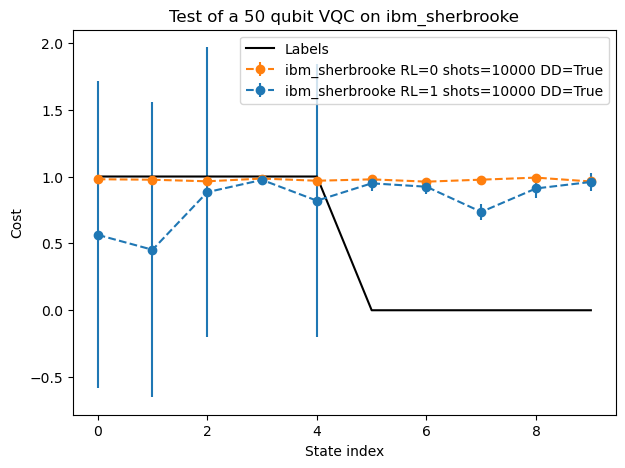

In [251]:
results_test_0_DD, errors_test_0_DD = retrieve_job('d06q4chqnmvg008jcf30') 
results_test_1_DD, errors_test_1_DD = retrieve_job('d06q4ht6rr3g008v110g') 

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title(f'Test of a {num_qubits} qubit VQC on {backend.name}')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
ax.errorbar(range(10), results_test_0_DD, fmt='--o', yerr=errors_test_0_DD, color='tab:orange', label=f'{backend.name} RL=0 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')
ax.errorbar(range(10), results_test_1_DD, fmt='--o',  yerr=errors_test_1_DD, color='tab:blue', label=f'{backend.name} RL=1 shots={options.default_shots} DD={options.dynamical_decoupling.enable}')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

##### Your results should look similar to the ones below. This is a previous job run using `ibm_kyiv`

Can you get better results?

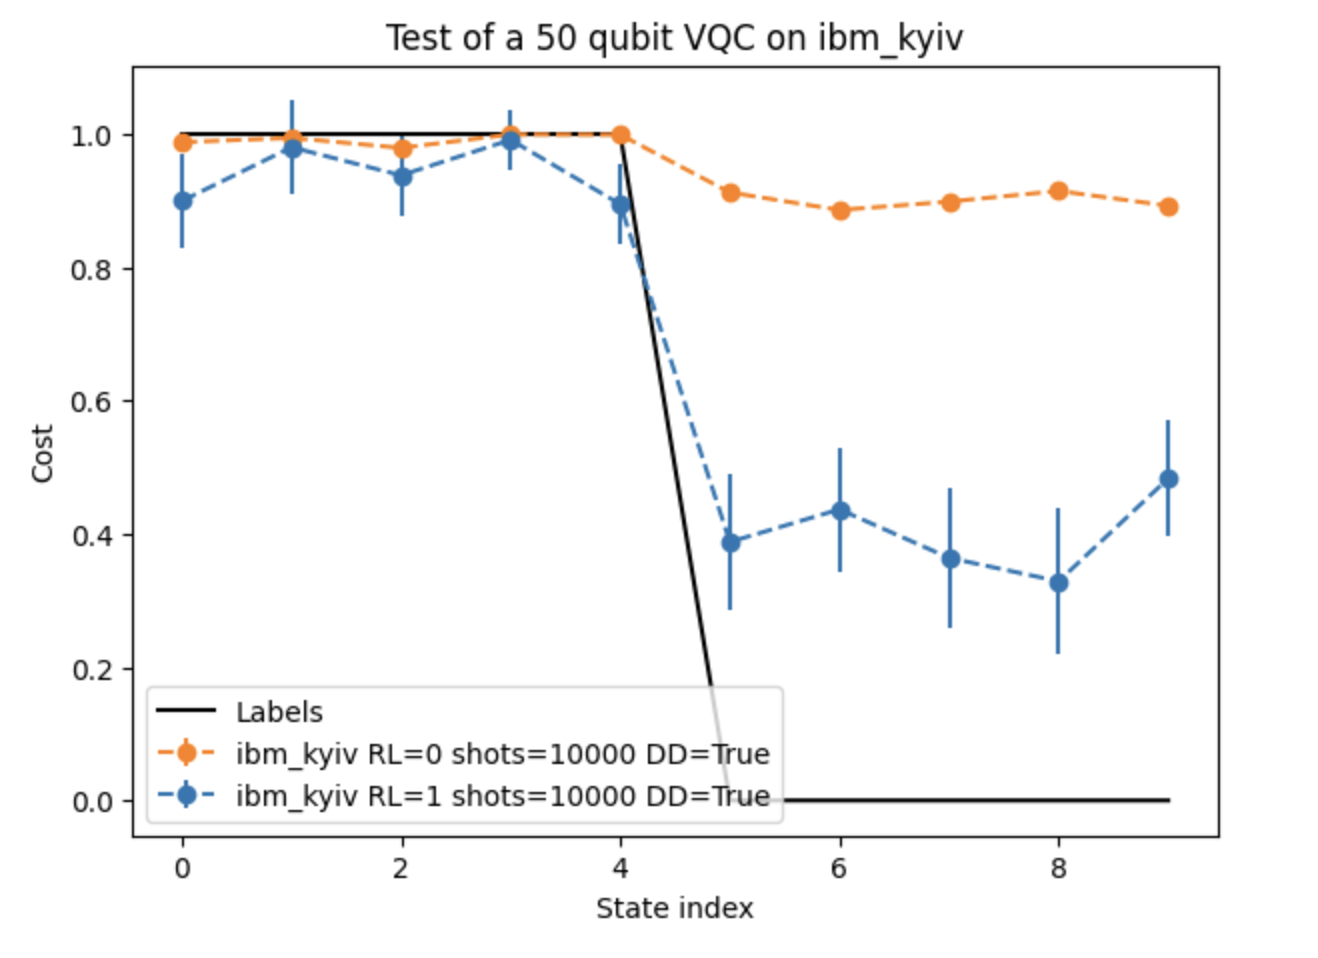

As always if you have questions please feel free to ask in the discord!